# Description

Final project for the class "Descriptive Learning", UFMG/2024-1


Jefferson Lopes

# Paper Abstract

This paper explores web usage mining techniques applied to e-commerce, utilizing a multi-approach analysis with descriptive learning methods. By analyzing a dataset sourced from Harvard Dataverse, containing 3.5GB of Nginx access log data from ”zanbil.ir,” the study aims to uncover actionable information to improve marketing strategies, website usability, and profitability. Key objectives include identifying frequently co-viewed or co-purchased products, understanding navigational patterns, and distinguishing characteristics of buyers versus non-buyers. The study employs itemset mining and subgroup discovery algorithms to extract non-trivial information, providing a robust methodology for iterative data mining and business decision support in e-commerce environments.

## 0 - Dependencies

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install mlxtend
!{sys.executable} -m pip install gsppy
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install sqlalchemy
!pip install ua-parser-up2date
!pip install orange3
!pip install pysubgroup


## 1 - Data Load & Preprocessing

In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model="Searchwise-co/l2-category-detection-augmented-data-epoch3")

In [ ]:
model = pipe
translation_map = {
    "0": "Tools and Spare Parts > Safety Tools",
    "1": "Tools and Spare Parts > Electric and Rechargeable Tools",
    "2": "Tools and Spare Parts > Precision and Measuring Tools",
    "3": "Tools and Spare Parts > Non-Electric Tools",
    "4": "Tools and Spare Parts > Gardening and Agriculture",
    "5": "Tools and Spare Parts > Traffic, Protection, and Security Equipment",
    "6": "Tools and Spare Parts > Industrial and Warehouse Equipment",
    "7": "Tools and Spare Parts > Car and Motorcycle",
    "8": "Tools and Spare Parts > Building Supplies and Materials",
    "9": "Tools and Spare Parts > Hardware",
    "10": "Recreation and Entertainment > Toys",
    "11": "Recreation and Entertainment > Digital Games",
    "12": "Recreation and Entertainment > Board Games",
    "13": "Recreation and Entertainment > Game Consoles",
    "14": "Home and Kitchen > Bathroom and Sanitary Services",
    "15": "Home and Kitchen > Decoration",
    "16": "Home and Kitchen > Lighting and Electrical",
    "17": "Home and Kitchen > Audio and Visual",
    "18": "Home and Kitchen > Cooking and Serving Utensils",
    "19": "Home and Kitchen > Kitchen Appliances",
    "20": "Home and Kitchen > Home Appliances",
    "21": "Home and Kitchen > Non-Electric Home Appliances",
    "22": "Home and Kitchen > Sewing Supplies",
    "23": "Home and Kitchen > Furniture",
    "24": "Home and Kitchen > Home and Kitchen Essentials",
    "25": "Home and Kitchen > Cleaning and Washing Supplies",
    "26": "Home and Kitchen > Textiles",
    "27": "Home and Kitchen > Pet Shop",
    "28": "Home and Kitchen > Bedding",
    "29": "Beauty and Health > Health Tools",
    "30": "Beauty and Health > Perfume and Cologne",
    "31": "Beauty and Health > Cosmetics",
    "32": "Beauty and Health > Hygiene Products",
    "33": "Beauty and Health > Personal Beauty Tools",
    "34": "Beauty and Health > Hair Care",
    "35": "Beauty and Health > Skin Care",
    "36": "Gold and Accessories > Personal Accessories",
    "37": "Gold and Accessories > Fashion Accessories",
    "38": "Gold and Accessories > Sports Accessories",
    "39": "Gold and Accessories > Gold Jewelry",
    "40": "Gold and Accessories > Non-Gold Jewelry",
    "41": "Gold and Accessories > Watches",
    "42": "Gold and Accessories > Gift Sets",
    "43": "Gold and Accessories > Gold Coins and Bullion",
    "44": "Gold and Accessories > Glasses",
    "45": "Gold and Accessories > Bags",
    "46": "Culture and Art > Handicrafts",
    "47": "Culture and Art > Movies",
    "48": "Culture and Art > Stationery",
    "49": "Culture and Art > Translator and Audiobooks",
    "50": "Culture and Art > Educational Content",
    "51": "Culture and Art > Religious Products",
    "52": "Culture and Art > Music",
    "53": "Culture and Art > Books and Magazines",
    "54": "Sports and Travel Equipment > Travel, Mountaineering, and Camping Equipment",
    "55": "Sports and Travel Equipment > Sports Equipment",
    "56": "Sports and Travel Equipment > Sportswear",
    "57": "Sports and Travel Equipment > Sports Shoes",
    "58": "Sports and Travel Equipment > Sports Bags",
    "59": "Fashion and Clothing > Clothing",
    "60": "Fashion and Clothing > Indigenous and Local Clothing",
    "61": "Fashion and Clothing > Shoes",
    "62": "Gift Card > Game Gift Card",
    "63": "Consumer Goods > Herbal Products",
    "64": "Consumer Goods > Mother and Child",
    "65": "Consumer Goods > Food",
    "66": "Consumer Goods > Nutritional and Pharmaceutical Supplements",
    "67": "Consumer Goods > Cleaning Supplies",
    "68": "Consumer Goods > Flowers and Plants",
    "69": "Digital Goods > Tablets and E-readers",
    "70": "Digital Goods > Security and Surveillance Equipment",
    "71": "Digital Goods > Laptop and Computer Accessories",
    "72": "Digital Goods > Cameras",
    "73": "Digital Goods > Smartwatches and Wristbands",
    "74": "Digital Goods > Internet Services and SIM Cards",
    "75": "Digital Goods > Digital Goods Accessories",
    "76": "Digital Goods > Laptops and Computers",
    "77": "Digital Goods > Office Machines",
    "78": "Digital Goods > Mobile Phones",
    "79": "Digital Goods > Headphones, Headsets, Earphones, and Microphones",
    "80": "Baby and Child > Hygiene and Bath",
    "81": "Baby and Child > Safety, Health, and Care",
    "82": "Baby and Child > Dining",
    "83": "Baby and Child > Personal Items",
    "84": "Baby and Child > Child Room Essentials",
    "85": "Baby and Child > Travel and Leisure Essentials",
    "86": "Baby and Child > Clothing"
}

model.model.config.id2label = {int(k): v for k, v in translation_map.items()}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re

log_file_path = '/content/drive/MyDrive/aprendizado_descritivo/access.log'
regex_pattern = r'^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[\w:/]+\s[+\-]\d{4})\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referer>[^"]*)" "(?P<user_agent>[^"]*)"'

columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

### Iterating over logs and saving it in a structured way

In [ ]:
log_data = []
reload_file = False

if reload_file:
  with open(log_file_path, 'r') as file:
      for i, line in enumerate(file):
          match = re.match(regex_pattern, line)
          if match:
              log_data.append({
                  'client': match.group('client'),
                  'userid': match.group('userid'),
                  'datetime': match.group('datetime'),
                  'method': match.group('method'),
                  'request': match.group('request'),
                  'status': match.group('status'),
                  'size': match.group('size'),
                  'referer': match.group('referer'),
                  'user_agent': match.group('user_agent')
              })
  logs_df = pd.DataFrame(log_data, columns=columns)
else:
  logs_df = pd.read_csv('/content/drive/MyDrive/aprendizado_descritivo/logs_df.csv')

### Saving loaded dataframe into CSV file

In [ ]:
if reload_file:
  logs_df.to_csv('/content/drive/MyDrive/aprendizado_descritivo/logs_df.csv', index=False)

## 2 - Data Cleaning

### Peak into the data

In [ ]:
# filter logs_df by client 54.36.149.41
logs_df[logs_df['client'] == '107.167.109.95']

,client,userid,datetime,method,request,status,size,referer,user_agent
1480586,107.167.109.95,-,22/Jan/2019:17:46:08 +0330,GET,/product/29043/%D9%85%D8%A7%D8%B4%DB%8C%D9%86-...,302,0,https://www.google.com/,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1480609,107.167.109.95,-,22/Jan/2019:17:46:10 +0330,GET,/m/product/29043/%D9%85%D8%A7%D8%B4%DB%8C%D9%8...,200,20700,https://www.zanbil.ir/product/29043/%D9%85%D8%...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1480685,107.167.109.95,-,22/Jan/2019:17:46:14 +0330,GET,/m/product/29043/%D9%85%D8%A7%D8%B4%DB%8C%D9%8...,200,20732,https://www.google.com/,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1480804,107.167.109.95,-,22/Jan/2019:17:46:18 +0330,GET,/settings/logo,200,4120,https://www.zanbil.ir/m/product/29043/%D9%85%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1487764,107.167.109.95,-,22/Jan/2019:17:49:49 +0330,POST,/comparison/add?__amp_source_origin=https%3A%2...,200,51,https://www.zanbil.ir/m/product/29043/%D9%85%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1489797,107.167.109.95,-,22/Jan/2019:17:50:58 +0330,GET,/basket/add/58248?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/29043/%D9%85%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1489853,107.167.109.95,-,22/Jan/2019:17:50:59 +0330,GET,/basket/view,200,17849,https://www.zanbil.ir/m/product/29043/%D9%85%D...,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1489912,107.167.109.95,-,22/Jan/2019:17:51:03 +0330,GET,/settings/logo,200,4120,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1490531,107.167.109.95,-,22/Jan/2019:17:51:33 +0330,GET,/login/auth,200,17171,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...
1490599,107.167.109.95,-,22/Jan/2019:17:51:36 +0330,GET,/settings/logo,200,4120,https://www.zanbil.ir/login/auth,Mozilla/5.0 (Linux; Android 6.0.1; SM-J106H Bu...


In [ ]:
# Get all unique file extension from logs_df request column
unique_extensions = set()
for request in logs_df['request']:
    a_match = re.search(r'\.([a-zA-Z]+)(?=\?|$)$', request)
    if a_match:
        unique_extensions.add(a_match.group(1))

In [ ]:
import itertools
for i, val in enumerate(itertools.islice(unique_extensions, 100)):
  print(val)

asp
visin
action
ir
B
htaccess
MB
sh
docx
cxo
msg
conf
json
COM
css
gif
CultureEvent
htm
jpg
zip
S
cur
LE
jsp
png
bak
FVC
org
DiscountNew
ico
js
PNG
Inch
exp
sql
env
html
htpasswd
woff
txt
svg
tar
E
php
DiscountNewDetail
KBS
JPG
ttf
swp
KBG
eot
SI
com
xml
k
SW
SSI
KBO
gz
Lg
rar


### Filtering URLs

In [ ]:
# Image and Assets Removal
to_remove_suffixes = (
    '.jpg',
    '.css',
    '.json',
    '.svg',
    '.jpeg',
    '.png',
    '.gif',
    '.ico',
    '.woff',
    '.js',
    'logo'
)

logs_df = logs_df[~logs_df['request'].str.startswith('/image/')]
logs_df = logs_df[~logs_df['request'].str.startswith('/static/')]
logs_df = logs_df[~logs_df['request'].str.startswith('/RSS/')]

logs_df = logs_df[~logs_df['request'].str.lower().str.endswith(to_remove_suffixes)]

#remove any request that contains the to_remove_suffixes, at any position
logs_df = logs_df[~logs_df['request'].str.contains('|'.join(to_remove_suffixes))]

In [ ]:
logs_df


,client,userid,datetime,method,request,status,size,referer,user_agent
0,54.36.149.41,-,22/Jan/2019:03:56:14 +0330,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
4,91.99.72.15,-,22/Jan/2019:03:56:17 +0330,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
8,66.249.66.194,-,22/Jan/2019:03:56:18 +0330,GET,"/filter/b41,b665,c150%7C%D8%A8%D8%AE%D8%A7%D8%...",200,34277,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
10,207.46.13.136,-,22/Jan/2019:03:56:18 +0330,GET,/product/10214,200,39677,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
12,178.253.33.51,-,22/Jan/2019:03:56:19 +0330,GET,/m/product/32574/62991/%D9%85%D8%A7%D8%B4%DB%8...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
...,...,...,...,...,...,...,...,...,...
8917319,86.105.41.211,-,26/Jan/2019:11:15:20 +0330,POST,/site/productPrice,200,707,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917324,86.105.41.211,-,26/Jan/2019:11:15:20 +0330,POST,/site/similarProducts,200,2156,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917325,54.36.148.111,-,26/Jan/2019:11:15:20 +0330,GET,/product/10713?model=15390,200,41965,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
8917332,5.202.255.25,-,26/Jan/2019:11:15:20 +0330,GET,"/filter?f=p65,b8,b213,b67,b3,b43,stexists&o=st",302,0,https://www.zanbil.ir/comparison/show,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...


In [ ]:
# Bot removal
logs_df = logs_df[~logs_df['user_agent'].str.endswith('http://www.baidu.com/search/spider.html)')]
logs_df = logs_df[~logs_df['user_agent'].str.endswith('http://www.bing.com/bingbot.htm)')]
logs_df = logs_df[~logs_df['user_agent'].str.endswith('http://mj12bot.com/)')]
logs_df = logs_df[~logs_df['user_agent'].str.endswith('http://yandex.com/bots)')]


logs_df = logs_df[~logs_df['request'].str.endswith('captcha')]

#logs_df = logs_df[~logs_df['request'].str.startswith('/filter/')]
logs_df = logs_df[~logs_df['request'].str.startswith('/amp-helper-frame.html')]

logs_df = logs_df[~logs_df['request'].str.endswith('alexaGooleAnalitic')]

#remove lines that the request is the path is just '/'
logs_df = logs_df[logs_df['request'] != '/']

#remove user agents that have the word "bot" in it
logs_df = logs_df[~logs_df['user_agent'].str.contains('bot')]

#remove user agents that have the word "spider" in it
logs_df = logs_df[~logs_df['user_agent'].str.contains('spider')]

#only maitain lines that contain the string '/product/' in the request
#logs_df = logs_df[logs_df['request'].str.contains('/product/')]

logs_df.head()

,client,userid,datetime,method,request,status,size,referer,user_agent
4,91.99.72.15,-,22/Jan/2019:03:56:17 +0330,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
12,178.253.33.51,-,22/Jan/2019:03:56:19 +0330,GET,/m/product/32574/62991/%D9%85%D8%A7%D8%B4%DB%8...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
14,91.99.72.15,-,22/Jan/2019:03:56:19 +0330,GET,/product/10075/13903/%D9%85%D8%A7%DB%8C%DA%A9%...,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
20,91.99.72.15,-,22/Jan/2019:03:56:20 +0330,GET,/product/32798/63266/%DB%8C%D8%AE%DA%86%D8%A7%...,200,40250,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
26,5.78.198.52,-,22/Jan/2019:03:56:21 +0330,GET,/m/product/33978/64784/%DA%AF%D9%88%D8%B4%DB%8...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...


### Parsing date strings to date objects

In [ ]:
from datetime import datetime
import pytz

def parse_datetime(x):
    try:
        dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
        dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
        return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))
    except ValueError:
        return '-'

logs_df['status'] = logs_df['status'].astype(int)
logs_df['size'] = logs_df['size'].astype(int)
logs_df['datetime'] = logs_df['datetime'].apply(parse_datetime)

In [ ]:
try:
    logs_df.drop(columns=['userid'], inplace=True)
except:
    pass

In [ ]:
logs_df = logs_df.drop_duplicates()

In [ ]:
logs_df

,client,datetime,method,request,status,size,referer,user_agent
4,91.99.72.15,2019-01-02 03:56:01+00:33,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
12,178.253.33.51,2019-01-02 03:56:01+00:33,GET,/m/product/32574/62991/%D9%85%D8%A7%D8%B4%DB%8...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
14,91.99.72.15,2019-01-02 03:56:01+00:33,GET,/product/10075/13903/%D9%85%D8%A7%DB%8C%DA%A9%...,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
20,91.99.72.15,2019-01-02 03:56:02+00:33,GET,/product/32798/63266/%DB%8C%D8%AE%DA%86%D8%A7%...,200,40250,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
26,5.78.198.52,2019-01-02 03:56:02+00:33,GET,/m/product/33978/64784/%DA%AF%D9%88%D8%B4%DB%8...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
...,...,...,...,...,...,...,...,...
8917315,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/productModelImages,200,1049,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917317,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/productCard,200,966,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917319,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/productPrice,200,707,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917324,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/similarProducts,200,2156,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...


In [ ]:
#get logs that have request as basket/add/*
logs_df[logs_df['request'].str.contains('/basket/add')]

,client,datetime,method,request,status,size,referer,user_agent
4383,5.117.242.204,2019-01-02 04:13:01+00:33,GET,/basket/add/55839?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/27456/55839/%D...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...
8756,204.18.175.72,2019-01-02 04:33:02+00:33,GET,/basket/add/5544?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/5334/11164/%D8...,Mozilla/5.0 (Linux; Android 6.0.1; SM-G532F) A...
10714,89.36.63.1,2019-01-02 04:39:04+00:33,GET,/basket/add/64714?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/33954/64716/%D...,Mozilla/5.0 (Linux; Android 5.0.2; SM-G850F) A...
19910,5.125.13.45,2019-01-02 05:18:03+00:33,GET,/basket/add/64756?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/33968/64756/%D...,Mozilla/5.0 (iPhone; CPU iPhone OS 11_3 like M...
44164,188.166.113.28,2019-01-02 06:44:03+00:33,GET,/basket/add/62139?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/31931/62139/%D...,Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like...
...,...,...,...,...,...,...,...,...
8904301,83.121.173.82,2019-01-06 11:10:05+00:33,GET,/basket/add/58772?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/29353/58772/%D...,Mozilla/5.0 (iPhone; CPU iPhone OS 12_1 like M...
8904685,5.202.255.25,2019-01-06 11:11:00+00:33,POST,/basket/add/64270?addedValues=,200,35,https://www.zanbil.ir/product/33603/64270/%D8%...,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...
8907647,5.211.68.190,2019-01-06 11:11:05+00:33,GET,/basket/add/176?mobile=1&addedValues=,302,0,https://www.zanbil.ir/m/product/4104/176/%D8%B...,Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like...
8908001,2.176.246.207,2019-01-06 11:12:00+00:33,POST,/basket/add/56756?addedValues=,200,35,https://www.zanbil.ir/product/28077/56756/%D9%...,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...


In [ ]:
test_string = '/basket/add/5544?mobile=1&addedValues='

re.search(r'/basket/add/(\d+)', test_string)[1]

'5544'

In [ ]:
unrecognized_product_class_urls = []
translation_cache = dict()

In [ ]:
import urllib.parse
example_product_string = '/product/10075/13903/%D9%85%D8%A7%DB%8C%DA%A9%D8%B1%D9%88%D9%81%D8%B1-%D8%B1%D9%88%D9%85%DB%8C%D8%B2%DB%8C-%D8%B3%D8%A7%D9%85%D8%B3%D9%88%D9%86%DA%AF-%D9%85%D8%AF%D9%84-CE288'


def get_product_class(url):
  decoded_url = urllib.parse.unquote(url)

  pattern = r'[^/]+$'

  url_match = re.search(pattern, decoded_url)

  if url_match:
      to_translate_text = url_match.group(0)
      if to_translate_text in translation_cache:
          return translation_cache[to_translate_text]
      else:
          pipe_result = pipe(to_translate_text)
          translation_cache[to_translate_text] = pipe_result[0]['label']
          return pipe_result[0]['label']
  else:
      unrecognized_product_class_urls.append(url)
      return 'N/A'

get_product_class(example_product_string)

'Home and Kitchen > Home Appliances'

In [ ]:
sessions = logs_df.groupby(['client', 'user_agent'])

In [ ]:
logs_df.groupby(['client', 'user_agent'])

In [ ]:
product_class_cache = dict()
product_id_class = dict()

In [ ]:
logs_df

,client,datetime,method,request,status,size,referer,user_agent
4,91.99.72.15,2019-01-02 03:56:01+00:33,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
12,178.253.33.51,2019-01-02 03:56:01+00:33,GET,/m/product/32574/62991/%D9%85%D8%A7%D8%B4%DB%8...,200,20406,https://www.zanbil.ir/m/filter/p5767%2Ct156?na...,Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...
14,91.99.72.15,2019-01-02 03:56:01+00:33,GET,/product/10075/13903/%D9%85%D8%A7%DB%8C%DA%A9%...,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
20,91.99.72.15,2019-01-02 03:56:02+00:33,GET,/product/32798/63266/%DB%8C%D8%AE%DA%86%D8%A7%...,200,40250,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
26,5.78.198.52,2019-01-02 03:56:02+00:33,GET,/m/product/33978/64784/%DA%AF%D9%88%D8%B4%DB%8...,200,21931,https://www.zanbil.ir/m/browse/cell-phone/%DA%...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
...,...,...,...,...,...,...,...,...
8917315,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/productModelImages,200,1049,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917317,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/productCard,200,966,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917319,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/productPrice,200,707,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
8917324,86.105.41.211,2019-01-06 11:15:02+00:33,POST,/site/similarProducts,200,2156,https://www.zanbil.ir/product/32087/%DB%8C%D8%...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...


In [ ]:
from ua_parser import user_agent_parser


In [ ]:
session_info = []
unknown_pages = dict()
basket_checkout_url = '/basket/checkout'
basket_add_url = '/basket/add'
product_url = '/product/'
order_created_url = '/order/create'


bad_url_list = [
    '/basket/provinces?__amp_source_origin=https%3A%2F%2Fwww.zanbil.ir',
    '/basket/cities?__amp_source_origin=https%3A%2F%2Fwww.zanbil.ir',
    '/m/track',
    '/m',
    '/customer/checkForActivationMail',
    '/discountLabel/get/3?type=mobileSmallIcon',
    '/basket/storeCustomerInformationWithoutRegistration',
    '/basket/storeShippingAddress',
    '/site/enamad',
    '/site/ping',
    '/basket/view',
    '/site/productPrice'
]

bad_url_session_list = [
    'admin'
]
def parse_page(page, debug=False):
    # Add / at the end of the page if it doesn't have so that the regex can correctly match
    if not page.endswith('/'):
        page += '/'

    # Skip known irrelevant endpoints
    if any(substring.lower() in page.lower() for substring in [
        'similarProducts',
        'productAdditives',
        'productModelImages',
        'productCard',
        'amp_preconnect_polyfill_404_or_other_error_expected',
        'orderAdministration',
        'specialSaleSlide',
        'pma.php',
        'enamad',
        'hacly.php',
        'test/wp-admin',
        'win.php',
        'productImage',
        'savePersonalInfo',
        'bulkUpdateProductTypesTree',
        'completionAndRemainingPayment',
        'storeShippingAddress',
        'system.php',
        '1213.php',
        'm.php',
        'sql/myadmin',
        'sql/websql',
        'sitemap.xml',
        'site/productImage',
        'event',
        'go',
        'content/view',
        'delivery/receipt',
        'comparison/alert',
        'basket/alert',
        'message/receive',
        '.txt',
        'php',
        'variationGroup',
        'changeCount',
        'spring',
        'pdf',
        'amp',
        '.rar',
        '.zip',
        '.tar',
        'discountLabel',
        'province',
        'getProductTypes',
    ]):
        return None

    # Recognize important pages
    if 'browse' in page and re.search(r'/browse/(.+?)/', page):
        category = re.search(r'/browse/(.+?)/', page)
        return "BR-" + category.group(1)
    elif 'product' in page and re.search(r'/product/(.+?)/(\d+)/', page):
        product = re.search(r'/product/(.+?)/(\d+)/', page)
        return "PR-" + product.group(2)
    elif 'product' in page and re.search(r'/product/(.+?)/', page):
        product = re.search(r'/product/(.+?)/', page)
        return "PR-" + product.group(1)
    elif 'article' in page and re.search(r'/article/(.+?)/', page):
        article = re.search(r'/article/(.+?)/', page)
        return "AR-" + article.group(1)
    elif 'filter' in page.lower():
      if 'rf' in page and ',rt' in page:
        return "FILTER-PRICE"
      elif re.search(r'b(\d+)/', page):
        return "FILTER-BRAND"
      else:
        return "FILTER-GENERIC"
    elif 'search' in page.lower():
        return "SEARCH"
    elif 'blog' in page.lower():
        return "BLOGPOST"
    elif 'checkout' in page.lower():
        return "CHECKOUT-OP"
    elif '/customer/register' in page.lower():
        return "REGISTER"
    elif '/login/auth' in page.lower():
        return "LOGIN"
    elif 'login_error' in page.lower():
        return "LOGIN-ERROR"
    elif 'giftCard' in page.lower():
        return "GIFT-CARD"
    elif '/basket/add' in page.lower():
        return "BA-" + re.search(r'/basket/add/(\d+)', page)[1]
    elif '/basket/remove' in page.lower():
        return "BASKET-REMOVE"
    elif '/basket/changeCount' in page.lower():
        return "BASKET-CHANGE"
    elif '/order/track' in page.lower():
        return "ORDER-TRACK"
    elif '/delivery/invoice' in page.lower():
        return "DELIVERY-INVOICE"
    elif '/delivery/receipt' in page.lower():
        return "DELIVERY-RECEIPT"
    elif '/orderAdministration/console' in page.lower():
        return "ORDER-ADMIN-CONSOLE"
    elif '/comparison/add' in page.lower():
        return "COMPARISON-ADD"
    elif '/comparison/remove' in page.lower():
        return "COMPARISON-REMOVE"
    elif '/content/view' in page.lower():
        return "CONTENT-VIEW"
    elif '/order/create/' in page.lower():
        return "ORDER-CREATE"
    elif '/order/completion' in page.lower():
        return "ORDER-COMPLETION"
    elif '/order/remainingPayment' in page.lower():
        return "ORDER-REMAINING"
    elif '/orderAdministration/act' in page.lower():
        return "ORDER-ACT"
    elif '/orderAdministration/assignCourier' in page.lower():
        return "ORDER-ASSIGN-COURIER"
    elif '/orderAdministration/editinfoinAdminorder' in page.lower():
        return "ORDER-EDIT-INFO"
    elif '/orderAdministration/printInvoice' in page.lower():
        return "ORDER-PRINT-INVOICE"
    elif '/orderAdministration/list/incomplete' in page.lower():
        return "ORDER-LIST-INCOMPLETE"
    elif '/orderAdministration/assignToMe' in page.lower():
        return "ORDER-ASSIGN-TO-ME"
    elif '/customer/activate' in page.lower():
        return "CUSTOMER-ACTIVATE"
    elif '/customer/saveBasicInfo' in page.lower():
        return "CUSTOMER-SAVE-BASIC-INFO"
    elif '/customer/savePersonalInfo' in page.lower():
        return "CUSTOMER-SAVE-PERSONAL-INFO"
    elif '/basket/storeCustomerInformationWithoutRegistration' in page.lower():
        return "BASKET-STORE-CUSTOMER"
    elif '/basket/storeShippingAddress' in page.lower():
        return "BASKET-STORE-SHIPPING"
    elif '/order/onlinePayment' in page.lower():
        return "ORDER-ONLINE-PAYMENT"
    elif '/order/notRegisteredPayment' in page.lower():
        return "ORDER-NOT-REGISTERED"
    elif '/order/deleteOrderItem' in page.lower():
        return "ORDER-DELETE-ITEM"
    elif '/order/registeredPayment' in page.lower():
        return "ORDER-REGISTERED-PAYMENT"
    elif '/productModel/form' in page.lower():
        return "PRODUCT-MODEL-FORM"
    elif '/productModel/productModelDetails' in page.lower():
        return "PRODUCT-MODEL-DETAILS"
    elif '/variationGroup/variationForm' in page.lower():
        return "VARIATION-FORM"
    elif '/province/getProvinceCities' in page.lower():
        return "GET-PROVINCE-CITIES"
    elif '/message/receive' in page.lower():
        return "MESSAGE-RECEIVE"
    elif '/comparison/show/' in page.lower():
        return "COMPARISON-SHOW"
    elif 'resetPassword' in page.lower():
        return "RESET-PASSWORD"
    elif 'forgotPassword' in page.lower():
        return "FORGOT-PASSWORD"
    elif '/delivery/orders/' in page.lower():
        return "DELIVERY-ORDERS"
    elif '/customer/panel/' in page.lower():
        return "CUSTOMER-PANEL"
    elif '/order/list/' in page.lower():
        return "ORDER-LIST"
    elif '/order/view/' in page.lower():
        return "ORDER-VIEW"

    # Collect unknown pages for further inspection
    if debug:
      print("page not known")
    if page in unknown_pages:
      unknown_pages[page] += 1
    else:
      unknown_pages[page] = 1
    return None

# Iterate over each session
for (client, user_agent), session_data in sessions:
    # Extract timestamps and page views for the session
    timestamps = session_data['datetime'].tolist()
    pages = session_data['request'].tolist()
    referer = session_data['referer'].tolist()
    basket_checkout_count = 0
    basket_add_count = 0
    product_count = 0
    order_created_count = 0
    product_classes = []
    session_time_bin = '< 1 Min'

    basket_add_bin = '0'
    product_visit_bin = '0'
    checked_out = False
    content_view = False
    comparision_add = False
    filter_generic = False
    filter_price = False
    filter_brand = False
    search = False
    blogpost = True

    # iterate over all pages and remove sequence duplicates. Ex: A, A, B, C, C should be A, B, C.
    # created parsed_timestamps and parsed_pages so that each filtered page has its corresponding timestamp
    parsed_timestamps = []
    parsed_pages = []
    cart_items = []

    parsed_string = user_agent_parser.ParseOS(user_agent)
    operational_system = parsed_string['family']

    is_mobile = False
    if 'Mobile' in user_agent:
      is_mobile = True

    should_skip_session = [any(bad_url.lower() in page.lower() for page in pages) for bad_url in bad_url_session_list]

    if any(should_skip_session):
      continue

    last_page = None
    for i, page in enumerate(pages):
      if page in bad_url_list:
        continue
      parsed_page = parse_page(page)
      if parsed_page and parsed_page != last_page:
        parsed_timestamps.append(timestamps[i])
        parsed_pages.append(parsed_page)

        last_page = parsed_page

        if basket_checkout_url in page:
          basket_checkout_count += 1
        elif basket_add_url in page:
          basket_add_count += 1
        elif product_url in page:
          product_count += 1
        elif order_created_url in page:
          order_created_count += 1

        if 'PR' in parsed_page and 'product/' in page:
          if parsed_page not in product_class_cache:
            product_class_cache[parsed_page] = get_product_class(page)

            page_to_parse = page
            if not page.endswith('/'):
              page_to_parse += '/'

            if re.search(r'/product/(.+?)/(.+?)/', page_to_parse):
              product_id = re.search(r'/product/(.+?)/(.+?)/', page_to_parse).group(2)
              product_id_class[product_id] = product_class_cache[parsed_page]

          product_classes.append(product_class_cache[parsed_page])

        if 'BA' in parsed_page and '/basket/add' in page:
          cart_items.append(parsed_page)

        if 'CHECKOUT-OP' in parsed_page:
          checked_out = True

        if 'CONTENT-VIEW' in parsed_page:
          content_view = True

        if 'FILTER-GENERIC' in parsed_page:
          filter_generic = True

        if 'FILTER-PRICE' in parsed_page:
          filter_price = True

        if 'FILTER-BRAND' in parsed_page:
          filter_brand = True

        if 'SEARCH' in parsed_page:
          search = True

        if 'COMPARISON-ADD' in parsed_page:
          comparision_add = True

        if 'BLOGPOST' in parsed_page:
          blogpost = True

    # Store session information in a tuple
    if len(parsed_pages) > 1:
      # Calculate a session time bin
      session_time = (parsed_timestamps[-1] - parsed_timestamps[0]).total_seconds() / 60

      if session_time < 1:
        session_time_bin = 'X < 1'
      elif session_time < 5:
        session_time_bin = f'1 < X < 5'
      elif session_time < 10:
        session_time_bin = f'5 < X < 10'
      elif session_time < 30:
        session_time_bin = f'10 < X < 30'
      elif session_time < 60:
        session_time_bin = f'30 < X < 60'
      elif session_time < 120:
        session_time_bin = f'60 < X < 120'
      else:
        session_time_bin = '120 < X'

      if basket_add_count == 1:
        basket_add_bin = '1'
      elif basket_add_count < 4:
        basket_add_bin = '1 < X < 4'
      elif basket_add_count >= 5:
        basket_add_bin = '5 <= X'

      if product_count == 1:
        product_visit_bin = '1'
      elif product_count < 4:
        product_visit_bin = '1 < X < 4'
      elif product_count < 10:
        product_visit_bin = '4 < X < 10'
      elif product_count >= 10:
        product_visit_bin = '10 <= X'



      # From the parsed_timestamps, find the most common day of the week (Mon, Tue, etc...)
      day_of_week = pd.Series([ts.day_name() for ts in parsed_timestamps]).value_counts().idxmax()

      session_info.append((client, operational_system, is_mobile, session_time_bin, blogpost, filter_generic, filter_price, filter_brand, search, comparision_add, day_of_week, parsed_pages, product_classes, cart_items, checked_out, content_view, basket_add_bin, product_visit_bin, basket_checkout_count, basket_add_count, product_count, order_created_count))

session_info_df = pd.DataFrame(session_info, columns=['client', 'operational_system', 'is_mobile', 'session_time_bin', 'blogpost', 'filter_generic', 'filter_price', 'filter_brand', 'search', 'comparision_add', 'day_of_week', 'pages', 'product_classes', 'cart_items', 'checked_out', 'content_view', 'basket_add_bin', 'product_visit_bin', 'basket_checkout_count', 'basket_add_count', 'product_visit_count', 'order_created_count'])
session_info_df.head()

,client,operational_system,is_mobile,session_time_bin,blogpost,filter_generic,filter_price,filter_brand,search,comparision_add,...,product_classes,cart_items,checked_out,content_view,basket_add_bin,product_visit_bin,basket_checkout_count,basket_add_count,product_visit_count,order_created_count
0,1.158.74.178,iOS,True,1 < X < 5,True,False,False,False,False,False,...,"[Beauty and Health > Perfume and Cologne, Beau...",[],False,False,1 < X < 4,1 < X < 4,0,0,3,0
1,1.36.128.224,iOS,True,X < 1,True,False,False,False,False,False,...,[],[],False,False,1 < X < 4,1 < X < 4,0,0,0,0
2,10.1.48.115,Windows,False,5 < X < 10,True,True,False,True,False,False,...,[Fashion and Clothing > Clothing],[],False,False,1 < X < 4,1,0,0,1,0
3,10.103.61.149,Windows,False,1 < X < 5,True,False,False,False,False,False,...,"[Fashion and Clothing > Clothing, Fashion and ...",[],False,False,1 < X < 4,1 < X < 4,0,0,3,0
4,10.104.208.32,Windows,False,1 < X < 5,True,False,False,False,True,False,...,[],[],False,False,1 < X < 4,1 < X < 4,0,0,0,0


In [ ]:
# Filter out sessions with 1 or less pages visited
session_info_df = session_info_df[session_info_df['pages'].apply(lambda x: len(x) > 1)]

# Filter out sessions with less than 1 min of duration
session_info_df = session_info_df[session_info_df['session_time_bin'] != 'X < 1']

In [ ]:
session_info_df[session_info_df['basket_add_count'] >= 1]

,client,operational_system,is_mobile,session_time_bin,blogpost,filter_generic,filter_price,filter_brand,search,comparision_add,...,product_classes,cart_items,checked_out,content_view,basket_add_bin,product_visit_bin,basket_checkout_count,basket_add_count,product_visit_count,order_created_count
14,10.114.99.92,Windows,False,10 < X < 30,True,True,False,True,False,False,...,"[Home and Kitchen > Audio and Visual, Fashion ...","[BA-64267, BA-64267]",True,False,1 < X < 4,1 < X < 4,2,2,3,0
28,10.145.254.153,Windows,False,120 < X,True,True,False,False,True,False,...,"[Digital Goods > Mobile Phones, Digital Goods ...",[BA-65271],True,False,1,4 < X < 10,1,1,6,1
36,10.233.251.23,Windows,False,10 < X < 30,True,True,False,True,False,False,...,"[Home and Kitchen > Home Appliances, Home and ...",[BA-11142],True,False,1,1 < X < 4,1,1,2,0
55,10.30.1.215,Windows,False,30 < X < 60,True,True,False,True,True,False,...,"[Home and Kitchen > Home Appliances, Home and ...","[BA-64634, BA-64632]",True,False,1 < X < 4,10 <= X,2,2,14,1
57,10.30.2.70,Windows,False,120 < X,True,True,False,True,False,False,...,"[Home and Kitchen > Home Appliances, Home and ...","[BA-64823, BA-60566]",True,False,1 < X < 4,4 < X < 10,2,2,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38999,95.64.37.77,Android,True,30 < X < 60,True,False,False,True,True,False,...,"[Digital Goods > Mobile Phones, Home and Kitch...",[BA-64756],False,False,1,1 < X < 4,0,1,2,0
39019,95.64.59.159,Android,True,10 < X < 30,True,False,False,False,False,False,...,[],[BA-11669],True,False,1,1 < X < 4,2,1,0,0
39020,95.64.59.39,Android,True,5 < X < 10,True,False,False,False,False,False,...,[N/A],[BA-64677],True,False,1,1,1,1,1,0
39083,95.80.164.20,Windows,False,120 < X,True,False,False,False,True,False,...,"[Home and Kitchen > Home Appliances, Home and ...","[BA-62880, BA-62880]",True,False,1 < X < 4,4 < X < 10,2,2,7,0


In [ ]:
session_info_df['cart_items_category'] = [[] for _ in range(len(session_info_df))]

In [ ]:
# iterate over the session_info_df dataframe and add a column 'cart_items_category'
# to do that, it should take the last digits of the cart items, like BA-XXXXX (the XXXXX, but the size isnt fixed) and
# check get the category from product_id_category
for index, row in session_info_df[session_info_df['basket_add_count'] >= 1].iterrows():
    cart_items_category = []
    cart_items = row['cart_items']
    for item in cart_items:
        item_id = re.search(r'BA-(.+)', item).group(1)
        if item_id in product_id_class:
            cart_items_category.append(product_id_class[item_id])
        else:
            cart_items_category.append('N/A')
    session_info_df.at[index, 'cart_items_category'] = cart_items_category

In [ ]:
session_info_df[session_info_df['client'] == '107.167.109.95']

,client,operational_system,is_mobile,session_time_bin,blogpost,filter_generic,filter_price,filter_brand,search,comparision_add,...,cart_items,checked_out,content_view,basket_add_bin,product_visit_bin,basket_checkout_count,basket_add_count,product_visit_count,order_created_count,cart_items_category
486,107.167.109.95,Android,True,60 < X < 120,True,False,False,False,False,False,...,"[BA-58248, BA-58248]",True,False,1 < X < 4,1 < X < 4,1,2,2,1,"[Beauty and Health > Personal Beauty Tools, Be..."


In [ ]:
# FILTER
# rf & rt => preço
# b => marca
#

In [ ]:
# Create new column purchased. Set to YES if order_created_count >= 1 or NO otherwise
session_info_df['purchased'] = session_info_df['order_created_count'].apply(lambda x: True if x >= 1 else False)

In [ ]:
# Create new column called pre_purchase_pages, that should contain all the contents of 'pages' but without the ones listed on an array
order_related_pages = [
    "CHECKOUT-OP",
    "REGISTER",
    "LOGIN",
    "LOGIN-ERROR",
    "GIFT-CARD",
    "ORDER-TRACK",
    "DELIVERY-INVOICE",
    "DELIVERY-RECEIPT",
    "ORDER-ADMIN-CONSOLE",
    "ORDER-CREATE",
    "ORDER-COMPLETION",
    "ORDER-REMAINING",
    "ORDER-ACT",
    "ORDER-ASSIGN-COURIER",
    "ORDER-EDIT-INFO",
    "ORDER-PRINT-INVOICE",
    "ORDER-LIST-INCOMPLETE",
    "ORDER-ASSIGN-TO-ME",
    "ORDER-ONLINE-PAYMENT",
    "ORDER-NOT-REGISTERED",
    "ORDER-DELETE-ITEM",
    "ORDER-REGISTERED-PAYMENT",
    "ORDER-LIST",
    "ORDER-VIEW",
    "PASSWORD-RESET",
    "FORGOT-PASSWORD",
    "DELIVERY-ORDERS",
    "CUSTOMER-PANEL",
    "CUSTOMER-ACTIVATE",
    "CUSTOMER-SAVE-BASIC-INFO",
    "CUSTOMER-SAVE-PERSONAL-INFO"
]


session_info_df['pre_purchase_pages'] = session_info_df['pages'].apply(lambda x: [i for i in x if i not in order_related_pages])


In [ ]:
session_info_df[session_info_df['basket_add_count'] >= 1]

,client,operational_system,is_mobile,session_time_bin,blogpost,filter_generic,filter_price,filter_brand,search,comparision_add,...,content_view,basket_add_bin,product_visit_bin,basket_checkout_count,basket_add_count,product_visit_count,order_created_count,cart_items_category,purchased,pre_purchase_pages
14,10.114.99.92,Windows,False,10 < X < 30,True,True,False,True,False,False,...,False,1 < X < 4,1 < X < 4,2,2,3,0,"[Home and Kitchen > Audio and Visual, Home and...",False,"[BR-tv, FILTER-BRAND, PR-64267, BA-64267, PR-3..."
28,10.145.254.153,Windows,False,120 < X,True,True,False,False,True,False,...,False,1,4 < X < 10,1,1,6,1,[Digital Goods > Mobile Phones],True,"[PR-31097, FILTER-GENERIC, PR-65274, PR-65271,..."
36,10.233.251.23,Windows,False,10 < X < 30,True,True,False,True,False,False,...,False,1,1 < X < 4,1,1,2,0,[Home and Kitchen > Home Appliances],False,"[FILTER-GENERIC, PR-11142, BA-11142, FILTER-GE..."
55,10.30.1.215,Windows,False,30 < X < 60,True,True,False,True,True,False,...,False,1 < X < 4,10 <= X,2,2,14,1,"[Home and Kitchen > Home Appliances, Home and ...",True,"[BR-home-appliances, FILTER-GENERIC, FILTER-BR..."
57,10.30.2.70,Windows,False,120 < X,True,True,False,True,False,False,...,False,1 < X < 4,4 < X < 10,2,2,6,0,"[Home and Kitchen > Home Appliances, Home and ...",False,"[FILTER-GENERIC, BR-stove-and-oven, FILTER-GEN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38999,95.64.37.77,Android,True,30 < X < 60,True,False,False,True,True,False,...,False,1,1 < X < 4,0,1,2,0,[Digital Goods > Mobile Phones],False,"[SEARCH, BR-cell-phone, FILTER-BRAND, PR-64756..."
39019,95.64.59.159,Android,True,10 < X < 30,True,False,False,False,False,False,...,False,1,1 < X < 4,2,1,0,0,[Home and Kitchen > Home Appliances],False,[BA-11669]
39020,95.64.59.39,Android,True,5 < X < 10,True,False,False,False,False,False,...,False,1,1,1,1,1,0,[N/A],False,"[PR-64677, BA-64677]"
39083,95.80.164.20,Windows,False,120 < X,True,False,False,False,True,False,...,False,1 < X < 4,4 < X < 10,2,2,7,0,"[Home and Kitchen > Home Appliances, Home and ...",False,"[PR-32506, SEARCH, PR-60971, SEARCH, PR-2132, ..."


In [ ]:
page = '/python.php/'
parse_page(page, True)

In [ ]:
# print unknow_pages by page frequency

#for page, frequency in sorted(unknown_pages.items(), key=lambda x: x[1], reverse=True):
#    print(f"{page}: {frequency}")

In [ ]:
session_info_df

,client,operational_system,is_mobile,session_time_bin,blogpost,filter_generic,filter_price,filter_brand,search,comparision_add,...,content_view,basket_add_bin,product_visit_bin,basket_checkout_count,basket_add_count,product_visit_count,order_created_count,cart_items_category,purchased,pre_purchase_pages
0,1.158.74.178,iOS,True,1 < X < 5,True,False,False,False,False,False,...,False,1 < X < 4,1 < X < 4,0,0,3,0,[],False,"[PR-60204, PR-60227, PR-60204]"
2,10.1.48.115,Windows,False,5 < X < 10,True,True,False,True,False,False,...,False,1 < X < 4,1,0,0,1,0,[],False,"[PR-30910, BR-cell-phone, FILTER-BRAND, FILTER..."
3,10.103.61.149,Windows,False,1 < X < 5,True,False,False,False,False,False,...,False,1 < X < 4,1 < X < 4,0,0,3,0,[],False,"[PR-11243, PR-11235, PR-23611]"
4,10.104.208.32,Windows,False,1 < X < 5,True,False,False,False,True,False,...,False,1 < X < 4,1 < X < 4,0,0,0,0,[],False,"[BR-cell-phone, SEARCH]"
7,10.106.226.45,Windows,False,1 < X < 5,True,True,False,False,False,False,...,False,1 < X < 4,1 < X < 4,0,0,2,0,[],False,"[FILTER-GENERIC, PR-62560, PR-1546]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39174,97.107.132.87,Android,True,120 < X,True,True,False,True,True,False,...,False,1 < X < 4,1,0,0,1,0,[],False,"[BR-air-conditioner-split, FILTER-GENERIC, SEA..."
39176,99.171.130.25,iOS,True,30 < X < 60,True,False,False,False,True,False,...,False,1 < X < 4,1,0,0,1,0,[],False,"[SEARCH, BR-home-appliances, BR-big-kitchen-ap..."
39178,99.243.47.93,Windows,False,1 < X < 5,True,False,False,False,False,False,...,False,1 < X < 4,1,0,0,1,0,[],False,"[PR-18939, BR-coffee-maker]"
39179,99.246.134.169,Windows,False,1 < X < 5,True,False,False,False,True,False,...,False,1 < X < 4,1 < X < 4,0,0,0,0,[],False,"[SEARCH, BR-digital-supplies, BR-digital-camer..."


In [ ]:
len(session_info_df[session_info_df['basket_add_count'] >= 1])

1811

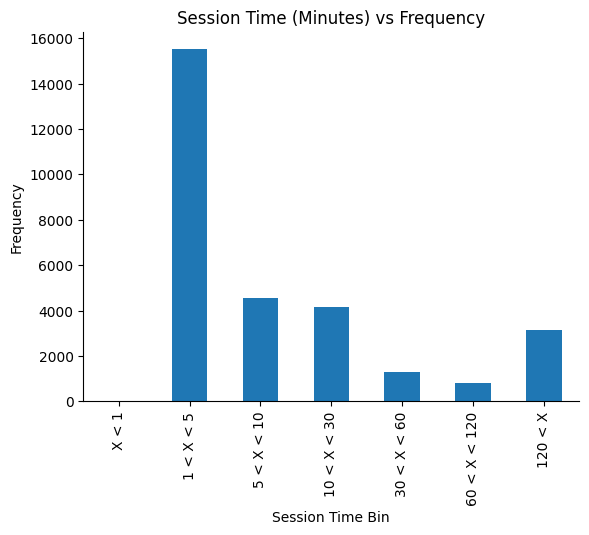

In [ ]:
from matplotlib import pyplot as plt
categories = ['X < 1', '1 < X < 5', '5 < X < 10', '10 < X < 30', '30 < X < 60', '60 < X < 120', '120 < X']

# Get the value counts and reindex to ensure the order
counts = session_info_df['session_time_bin'].value_counts().reindex(categories, fill_value=0)

counts.plot(kind='bar', title='Session Time (Minutes) vs Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Session Time Bin')
plt.ylabel('Frequency')
plt.show()

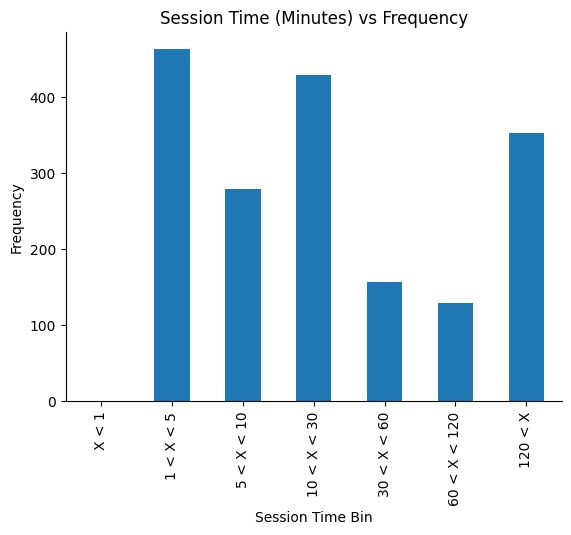

In [ ]:
from matplotlib import pyplot as plt
counts = session_info_df[session_info_df['basket_add_count'] >= 1]['session_time_bin'].value_counts().reindex(categories, fill_value=0)

counts.plot(kind='bar', title='Session Time (Minutes) vs Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Session Time Bin')
plt.ylabel('Frequency')
plt.show()

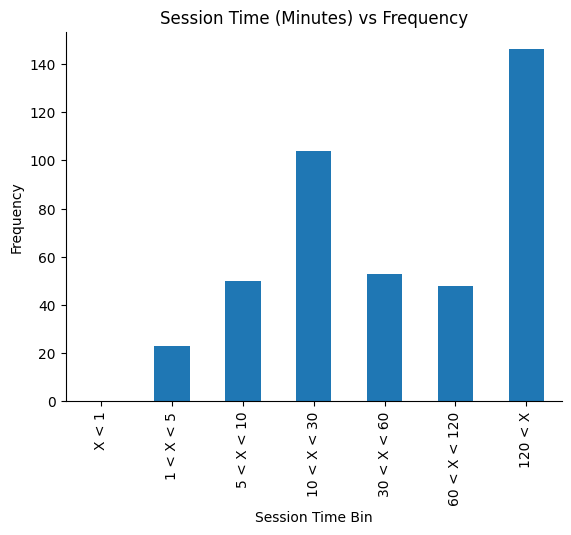

In [ ]:
from matplotlib import pyplot as plt
counts = session_info_df[session_info_df['order_created_count'] >= 1]['session_time_bin'].value_counts().reindex(categories, fill_value=0)

counts.plot(kind='bar', title='Session Time (Minutes) vs Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Session Time Bin')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# show number of rows that have basket_checkout_count >= 1
session_info_df[session_info_df['basket_checkout_count'] >= 1].shape[0]

1380

In [ ]:
# save session_info_df to a sqlite
save_to_sql = False
if save_to_sql:
  from sqlalchemy import create_engine
  import json
  session_info_serialized_df = session_info_df.copy()

  # Convert lists and Timestamps to JSON strings
  session_info_serialized_df['timestamps'] = session_info_serialized_df['timestamps'].apply(lambda x: json.dumps([ts.isoformat() for ts in x]))
  session_info_serialized_df['pages'] = session_info_serialized_df['pages'].apply(lambda x: json.dumps(x))

  # Create SQLite engine
  engine = create_engine('sqlite:///session_info.db')

  # Save the modified DataFrame to SQLite
  session_info_serialized_df.to_sql('session_info', con=engine, if_exists='replace', index=False)

In [ ]:
text = "آچار"

# Classify the text
result = pipe(text)
result

[{'label': 'Tools and Spare Parts > Non-Electric Tools',
  'score': 0.9493674635887146}]

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import association_rules

# Relevant sets across sessions

## All sessions

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
session_df = session_info_df
# Convert pages visited per session into a list of lists format
pages_accessed = session_info_df['pages'].tolist()
irrelevant_pages = ['FILTER', 'SEARCH', 'REGISTER', "LOGIN"]

def remove_pages(page_list):
  return [i for i in page_list if i not in irrelevant_pages]

# Remove FILTER and SEARCH from the pages

filtered_all_pages_accessed = [remove_pages(page_list) for page_list in pages_accessed]

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit and transform the data into a one-hot encoded DataFrame
onehot = te.fit_transform(filtered_all_pages_accessed)

# Convert the one-hot encoded DataFrame into a DataFrame
df = pd.DataFrame(onehot, columns=te.columns_)

# Find frequent itemsets using Apriori with minimum support of 0.03
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

filter_frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) > 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print("Frequent Itemsets:")
# show filter_frequent_itemsets ordered by support
filter_frequent_itemsets.sort_values(by='support', ascending=False)

Frequent Itemsets:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
86,0.216470,"(FILTER-BRAND, FILTER-GENERIC)"
67,0.062958,"(BR-home-appliances, FILTER-GENERIC)"
74,0.055262,"(BR-refrigerator-and-freezer, FILTER-GENERIC)"
56,0.047362,"(BR-cell-phone, FILTER-GENERIC)"
77,0.043497,"(BR-tv, FILTER-GENERIC)"
...,...,...
91,0.010442,"(BR-home-appliances, FILTER-GENERIC, BR-audio-..."
108,0.010273,"(BR-tv, BR-home-appliances, FILTER-GENERIC)"
93,0.010273,"(FILTER-BRAND, FILTER-GENERIC, BR-audio-and-vi..."
89,0.010205,"(PR-64719, FILTER-GENERIC)"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Generate association rules with a minimum confidence of 0.1
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the rules
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(CHECKOUT-OP),(FILTER-BRAND),1.000000,0.315942,0.315942,0.315942,1.0,0.0,1.0,0.0
1,(FILTER-BRAND),(CHECKOUT-OP),0.315942,1.000000,0.315942,1.000000,1.0,0.0,inf,0.0
2,(CHECKOUT-OP),(FILTER-GENERIC),1.000000,0.521739,0.521739,0.521739,1.0,0.0,1.0,0.0
3,(FILTER-GENERIC),(CHECKOUT-OP),0.521739,1.000000,0.521739,1.000000,1.0,0.0,inf,0.0
4,(CHECKOUT-OP),(LOGIN),1.000000,0.294928,0.294928,0.294928,1.0,0.0,1.0,0.0
5,(LOGIN),(CHECKOUT-OP),0.294928,1.000000,0.294928,1.000000,1.0,0.0,inf,0.0
6,(CHECKOUT-OP),(ORDER-CREATE),1.000000,0.303623,0.303623,0.303623,1.0,0.0,1.0,0.0
7,(ORDER-CREATE),(CHECKOUT-OP),0.303623,1.000000,0.303623,1.000000,1.0,0.0,inf,0.0
8,(REGISTER),(CHECKOUT-OP),0.256522,1.000000,0.256522,1.000000,1.0,0.0,inf,0.0
9,(CHECKOUT-OP),(REGISTER),1.000000,0.256522,0.256522,0.256522,1.0,0.0,1.0,0.0


## Only sessions that added at least one product to the cart



In [ ]:
# Convert pages visited per session into a list of lists format
pages_accessed = session_info_df[session_info_df['basket_add_count'] >= 1]['product_classes'].tolist()

def remove_pages(page_list):
  return page_list
  #return [i for i in page_list if i != 'FILTER' and i != 'SEARCH']

# Remove FILTER and SEARCH from the pages

filtered_all_pages_accessed = [remove_pages(page_list) for page_list in pages_accessed]

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit and transform the data into a one-hot encoded DataFrame
onehot = te.fit_transform(filtered_all_pages_accessed)

# Convert the one-hot encoded DataFrame into a DataFrame
df = pd.DataFrame(onehot, columns=te.columns_)

# Find frequent itemsets using Apriori with minimum support of 0.03
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

filter_frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) > 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print("Frequent Itemsets:")
# show filter_frequent_itemsets ordered by support
filter_frequent_itemsets.sort_values(by='support', ascending=False)

Frequent Itemsets:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
20,0.033683,"(Home and Kitchen > Audio and Visual, Home and..."
18,0.025953,"(N/A, Digital Goods > Mobile Phones)"
19,0.023192,"(Fashion and Clothing > Clothing, Home and Kit..."
21,0.016565,"(Home and Kitchen > Home Appliances, N/A)"
17,0.013805,"(Home and Kitchen > Home Appliances, Digital G..."
16,0.012700,"(Beauty and Health > Personal Beauty Tools, Ho..."
22,0.012148,"(Home and Kitchen > Home Appliances, Tools and..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(N/A),(Digital Goods > Mobile Phones),0.063501,0.120375,0.025953,0.408696,3.395174,0.018309,1.487600,0.753299
1,(Digital Goods > Mobile Phones),(N/A),0.120375,0.063501,0.025953,0.215596,3.395174,0.018309,1.193900,0.802006
2,(Fashion and Clothing > Clothing),(Home and Kitchen > Home Appliances),0.036444,0.547211,0.023192,0.636364,1.162921,0.003249,1.245168,0.145395
3,(Home and Kitchen > Home Appliances),(Fashion and Clothing > Clothing),0.547211,0.036444,0.023192,0.042381,1.162921,0.003249,1.006200,0.309408


## Only sessions that created an order

In [ ]:
# Convert pages visited per session into a list of lists format
pages_accessed = session_info_df[session_info_df['order_created_count'] >= 1]['product_classes'].tolist()

def remove_pages(page_list):
  return page_list
  #return [i for i in page_list if 'PR' in i]

# Remove FILTER and SEARCH from the pages

filtered_all_pages_accessed = [remove_pages(page_list) for page_list in pages_accessed]

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit and transform the data into a one-hot encoded DataFrame
onehot = te.fit_transform(filtered_all_pages_accessed)

# Convert the one-hot encoded DataFrame into a DataFrame
df = pd.DataFrame(onehot, columns=te.columns_)

# Find frequent itemsets using Apriori with minimum support of 0.03
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

filter_frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) > 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print("Frequent Itemsets:")
# show filter_frequent_itemsets ordered by support
filter_frequent_itemsets.sort_values(by='support', ascending=False)

Frequent Itemsets:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
25,0.037736,"(Home and Kitchen > Audio and Visual, Home and..."
21,0.028302,"(Beauty and Health > Personal Beauty Tools, Ho..."
22,0.028302,"(Home and Kitchen > Home Appliances, Digital G..."
24,0.023585,"(Fashion and Clothing > Clothing, Home and Kit..."
28,0.023585,"(Home and Kitchen > Home Appliances, N/A)"
26,0.018868,"(Home and Kitchen > Home Appliances, Home and ..."
23,0.016509,"(N/A, Digital Goods > Mobile Phones)"
20,0.014151,"(Beauty and Health > Health Tools, Home and Ki..."
29,0.014151,"(Home and Kitchen > Home Appliances, Tools and..."
27,0.011792,"(Home and Kitchen > Home Appliances, Home and ..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(N/A),(Digital Goods > Mobile Phones),0.049528,0.110849,0.016509,0.333333,3.007092,0.011019,1.333726,0.702233
1,(Digital Goods > Mobile Phones),(N/A),0.110849,0.049528,0.016509,0.148936,3.007092,0.011019,1.116804,0.750663
2,(Fashion and Clothing > Clothing),(Home and Kitchen > Home Appliances),0.035377,0.533019,0.023585,0.666667,1.250737,0.004728,1.400943,0.207824
3,(Home and Kitchen > Home Appliances),(Fashion and Clothing > Clothing),0.533019,0.035377,0.023585,0.044248,1.250737,0.004728,1.009281,0.429293


## Products added to the basket

In [ ]:
# Certifique-se de ter a biblioteca mlxtend instalada:
# !pip install mlxtend

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

# Convert pages visited per session into a list of lists format
pages_accessed = session_info_df[session_info_df['basket_add_count'] > 1]['cart_items_category'].tolist()

def remove_pages(page_list):
    return page_list
    #return [i for i in page_list if 'PR' in i]

# Remove FILTER and SEARCH from the pages
filtered_all_pages_accessed = [remove_pages(page_list) for page_list in pages_accessed]

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit and transform the data into a one-hot encoded DataFrame
onehot = te.fit_transform(filtered_all_pages_accessed)

# Convert the one-hot encoded DataFrame into a DataFrame
df = pd.DataFrame(onehot, columns=te.columns_)

# Find frequent itemsets using FP-Growth with minimum support of 0.01
frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)

# Filter frequent itemsets to only include those with more than one item
filter_frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) > 1]

print("Frequent Itemsets:")
# Show filtered frequent itemsets ordered by support
filter_frequent_itemsets.sort_values(by='support', ascending=False)


Frequent Itemsets:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
13,0.040712,"(Home and Kitchen > Audio and Visual, Home and..."
15,0.022901,"(Home and Kitchen > Home Appliances, N/A)"
14,0.010178,"(N/A, Digital Goods > Mobile Phones)"
16,0.010178,"(Home and Kitchen > Home Appliances, Tools and..."


In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Home and Kitchen > Audio and Visual),(Home and Kitchen > Home Appliances),0.124682,0.559796,0.040712,0.326531,0.583302,-0.029084,0.653636,-0.449380
1,(Home and Kitchen > Home Appliances),(Home and Kitchen > Audio and Visual),0.559796,0.124682,0.040712,0.072727,0.583302,-0.029084,0.943970,-0.618733
2,(N/A),(Digital Goods > Mobile Phones),0.055980,0.091603,0.010178,0.181818,1.984848,0.005050,1.110263,0.525606
3,(Digital Goods > Mobile Phones),(N/A),0.091603,0.055980,0.010178,0.111111,1.984848,0.005050,1.062023,0.546218
4,(Home and Kitchen > Home Appliances),(N/A),0.559796,0.055980,0.022901,0.040909,0.730785,-0.008436,0.984287,-0.455594
5,(N/A),(Home and Kitchen > Home Appliances),0.055980,0.559796,0.022901,0.409091,0.730785,-0.008436,0.744960,-0.280698


## Graph of relevant page pairs

In [ ]:
import networkx as nx
import plotly.graph_objs as go
from collections import Counter

# Initialize directed graph
G = nx.DiGraph()
filtered_session_df = session_info_df[session_info_df['basket_checkout_count'] >= 1]

# Process each session to add edges to the graph
edge_list = []
for session in filtered_session_df['client'].unique():
    session_data = filtered_session_df[filtered_session_df['client'] == session]
    pages = session_data['pages'].tolist()

    # Ensure pages list is flat
    if len(pages) > 1 and isinstance(pages[0], list):
        pages = pages[0]  # If pages is a list of lists, take the first list

    # Ensure pages list is not empty
    if len(pages) > 1:
        # Create edges from consecutive page visits
        edges = [(pages[i], pages[i+1]) for i in range(len(pages)-1)]
        edge_list.extend(edges)

# Count frequency of each edge
edge_counter = Counter(edge_list)

# Filter to get top N most common edges
top_edges = edge_counter.most_common(1000)

# Identify top 5 most common paths (edges)
top_5_edges = [edge for edge, weight in edge_counter.most_common(50)]

# Add filtered edges with weights to the graph
for edge, weight in top_edges:
    G.add_edge(edge[0], edge[1], weight=weight)

# Create plotly graph
pos = nx.spring_layout(G, k=0.5)  # You can adjust the value of k for better spacing
edge_trace = []
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(size=10, color='skyblue'),
)

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    node_trace['text'] += (node,)

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = edge[2]['weight']
    color = 'red' if (edge[0], edge[1]) in top_5_edges else 'gray'
    edge_trace.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=weight * 0.1, color=color),
            hoverinfo='none',
            mode='lines'
        )
    )

fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(
                    title='Interactive User Navigation Graph with Top 5 Paths Highlighted',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Behaviour-based user segmentation

## Function definitions

In [ ]:
import networkx as nx
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def jaccard_similarity(sg1, sg2, dataset):
    sg1_cover = sg1.covers(dataset)
    sg2_cover = sg2.covers(dataset)
    intersection = np.sum(sg1_cover & sg2_cover)
    union = np.sum(sg1_cover | sg2_cover)
    return intersection / union if union > 0 else 0

def create_overlap_matrix(df, dataset):
    n = len(df)
    overlap = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            overlap[i, j] = jaccard_similarity(df['subgroup'].iloc[i], df['subgroup'].iloc[j], dataset)
    return pd.DataFrame(overlap, index=df.index, columns=df.index)

def prune_and_visualize(result_df, dataset):
    # Create graph
    G = nx.Graph()

    # Add nodes
    for idx, row in result_df.iterrows():
        G.add_node(idx, wracc=row['quality'], subgroup=row['subgroup'])  # Assuming 'quality' represents WRAcc score and 'subgroup' is the attribute to display

    # Calculate similarities and add edges
    for i, row1 in result_df.iterrows():
        for j, row2 in result_df.iterrows():
            if i < j:
                similarity = jaccard_similarity(row1['subgroup'], row2['subgroup'], dataset)
                if similarity > 0.5:  # TJ = 1/2
                    G.add_edge(i, j, weight=1-similarity)  # Using 1-similarity for MST calculation

    # Find connected components
    components = list(nx.connected_components(G))

    # Create MST for each component
    MST = nx.Graph()
    for component in components:
        subgraph = G.subgraph(component)
        mst = nx.minimum_spanning_tree(subgraph)
        MST.add_edges_from(mst.edges(data=True))
        MST.add_nodes_from(subgraph.nodes(data=True))

    # Select highest WRAcc score from each component
    selected_nodes = []
    unique_data = []
    for component in components:
        best_node = max(component, key=lambda x: G.nodes[x]['wracc'])
        selected_nodes.append(best_node)
        unique_data.append(G.nodes[best_node])

    # Create a new DataFrame for unique subgroups
    unique_df = pd.DataFrame(unique_data)

    # Initialize positions
    pos = {}
    component_centers = []

    # Set initial component center coordinates
    initial_x, initial_y = 0.5, 0.5
    offset = 0.9  # Reduce the distance between component centers

    # Calculate positions for each component
    for comp_idx, component in enumerate(components):
        # Calculate center for current component
        comp_center_x = initial_x + (comp_idx % 3) * offset
        comp_center_y = initial_y + (comp_idx // 3) * offset
        component_centers.append((comp_center_x, comp_center_y))

        # Central position for selected nodes in the current component
        center_x, center_y = comp_center_x, comp_center_y
        radius = 0.2
        angle_step = 2 * np.pi / len(selected_nodes)

        # Place selected nodes in a circle around the center
        for i, node in enumerate(selected_nodes):
            if node in component:
                angle = i * angle_step
                pos[node] = (center_x + radius * np.cos(angle), center_y + radius * np.sin(angle))

        # Place other nodes around their corresponding selected node
        for node in component:
            if node not in selected_nodes:
                # Find the closest selected node
                closest_selected_node = min(selected_nodes, key=lambda x: nx.shortest_path_length(MST, source=node, target=x) if x in component else float('inf'))
                angle = np.random.uniform(0, 2 * np.pi)
                distance = np.random.uniform(0.05, 0.1)
                pos[node] = (
                    pos[closest_selected_node][0] + distance * np.cos(angle),
                    pos[closest_selected_node][1] + distance * np.sin(angle)
                )

    # Generate unique colors for each selected node
    colors = [
        f'rgba({r},{g},{b},0.8)'
        for r, g, b in zip(np.random.randint(0, 255, len(selected_nodes)), np.random.randint(0, 255, len(selected_nodes)), np.random.randint(0, 255, len(selected_nodes)))
    ]

    # Prepare for visualization
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in MST.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers+text',
        textposition='top center',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='WRAcc Score',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

    for node in MST.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        if node in selected_nodes:
            node_trace['text'] += tuple([f'<span style="background-color: rgba(255, 255, 255, 0.8); padding: 2px; border-radius: 3px;">Subgroup: {MST.nodes[node]["subgroup"]}<br>WRAcc: {MST.nodes[node]["wracc"]:.3f}</span>'])
        else:
            node_trace['text'] += tuple([""])

    # Color nodes based on selection
    node_color_map = [colors[selected_nodes.index(node)] if node in selected_nodes else 'rgba(255, 255, 255, 0.8)' for node in MST.nodes()]
    node_trace['marker']['color'] = node_color_map

    # Create the figure with square aspect ratio
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Subgroup Network (MST)',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor="y", scaleratio=1),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, scaleanchor="x", scaleratio=1))
                    )

    fig.show()

    # Create overlap matrix
    overlap_matrix = create_overlap_matrix(unique_df, dataset)

    # Plot overlap matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(overlap_matrix, annot=True, cmap='YlGnBu')
    plt.title('Subgroup Overlap (Jaccard Similarity)')
    plt.tight_layout()
    plt.show()

    # Return the unique subgroups DataFrame
    return unique_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Users that abandoned the cart

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



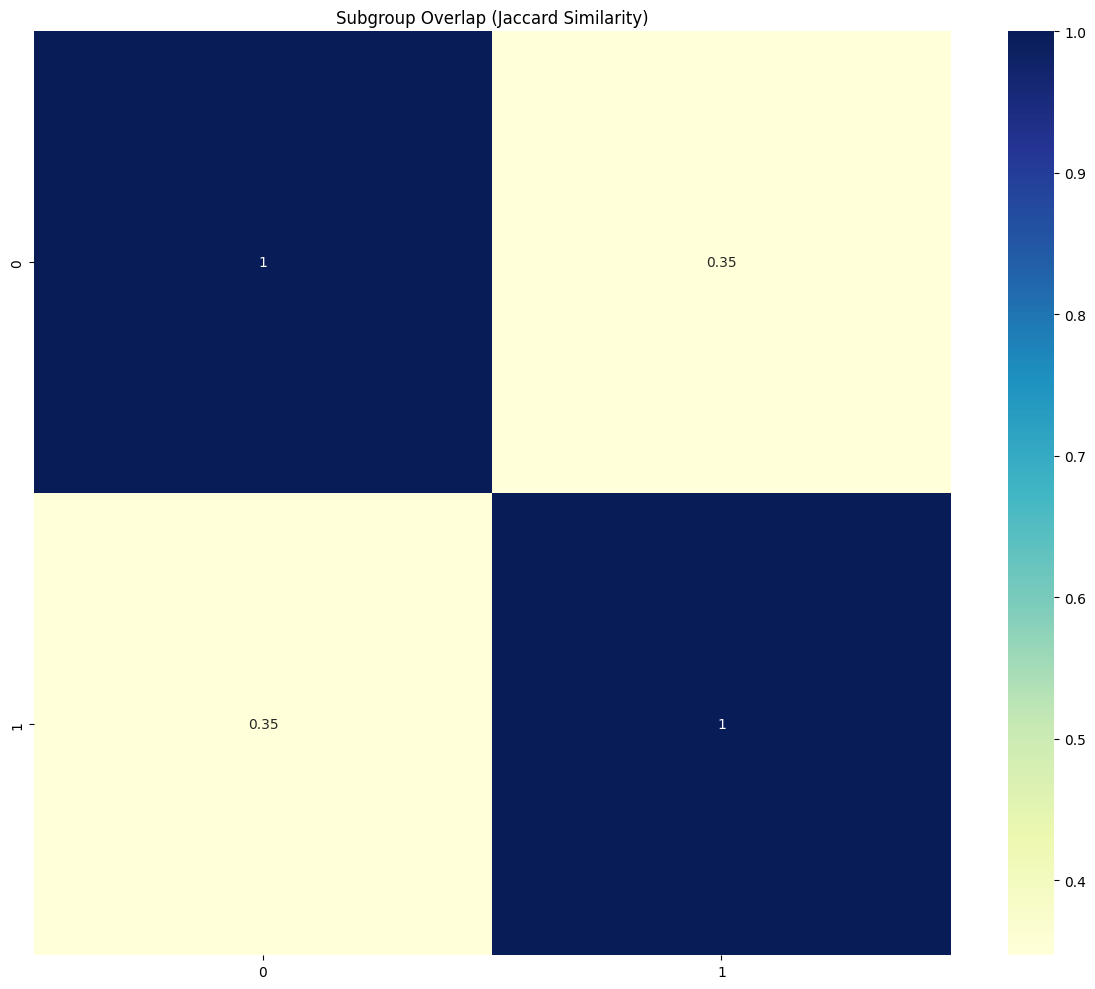

,wracc,subgroup
0,0.050190,basket_add_bin=='1' AND search==False
1,0.046952,session_time_bin=='1 < X < 5'


In [ ]:
import pysubgroup as ps

target = ps.BinaryTarget ('purchased', False)
dataset = session_info_df[session_info_df['basket_add_count'] >= 1]

searchspace = ps.create_selectors(dataset, ignore=[ 'purchased','checked_out', 'pages', 'product_classes', 'cart_items', 'cart_items_category', 'pre_purchase_pages', 'basket_checkout_count',  'basket_add_count',  'product_visit_count',  'order_created_count', 'client'])
task = ps.SubgroupDiscoveryTask (
    dataset,
    target,
    searchspace,
    result_set_size=200,
    depth=4,
    qf=ps.WRAccQF())
result = ps.DFS().execute(task)

pruned_df = prune_and_visualize(result.to_dataframe(), dataset)
pruned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



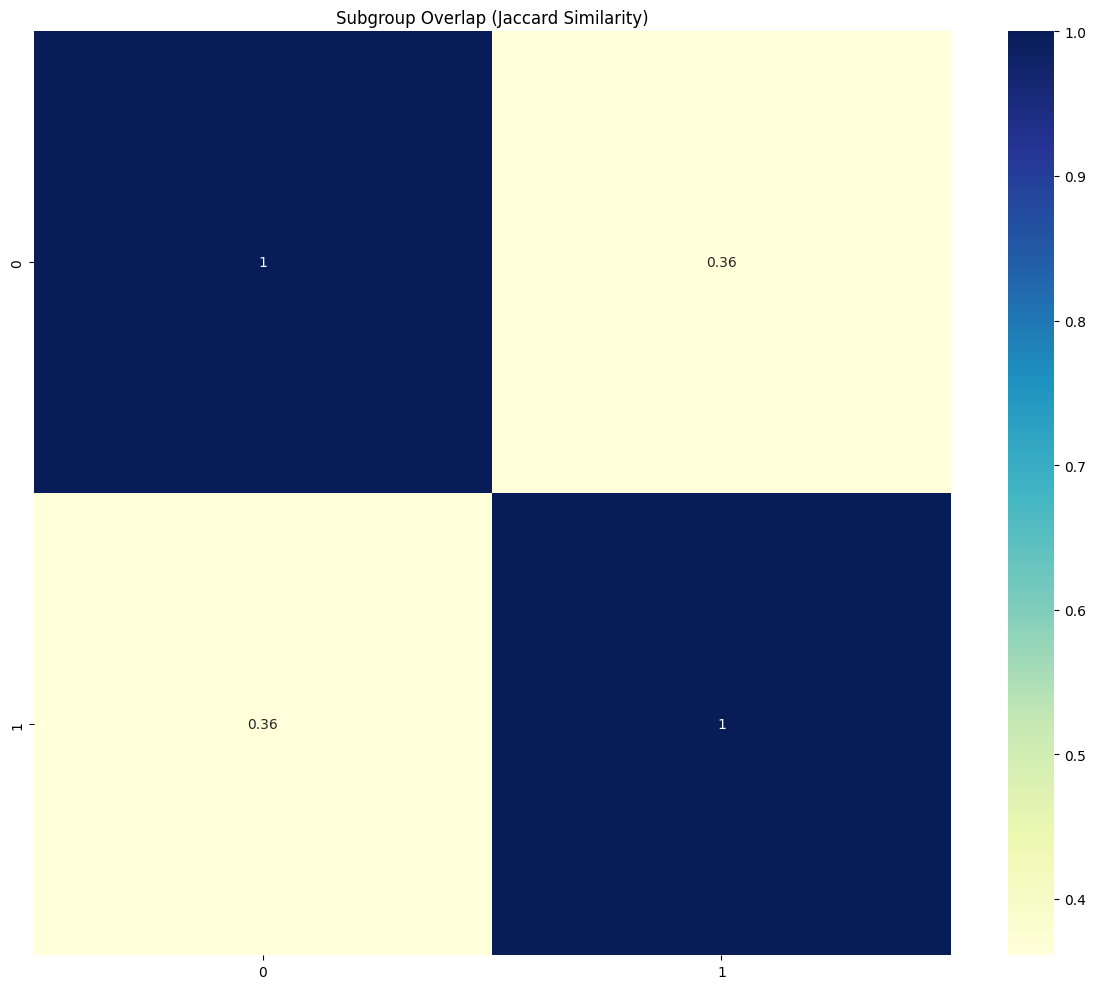

,wracc,subgroup
0,0.044145,session_time_bin=='1 < X < 5'
1,0.033291,basket_add_bin=='1' AND operational_system=='A...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import pysubgroup as ps

target = ps.BinaryTarget ('purchased', False)
# dataset of users that inserted items in the cart and are on mobile
dataset = session_info_df[(session_info_df['basket_add_count'] >= 1) & (session_info_df['search'] == False)]

searchspace = ps.create_selectors(dataset, ignore=['purchased','checked_out', 'pages', 'product_classes', 'cart_items', 'cart_items_category', 'pre_purchase_pages', 'basket_checkout_count',  'basket_add_count',  'product_visit_count',  'order_created_count', 'client'])
task = ps.SubgroupDiscoveryTask (
    dataset,
    target,
    searchspace,
    result_set_size=200,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch(beam_width_adaptive=True).execute(task)

pruned_df = prune_and_visualize(result.to_dataframe(), dataset)
pruned_df

## Users that purchased

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



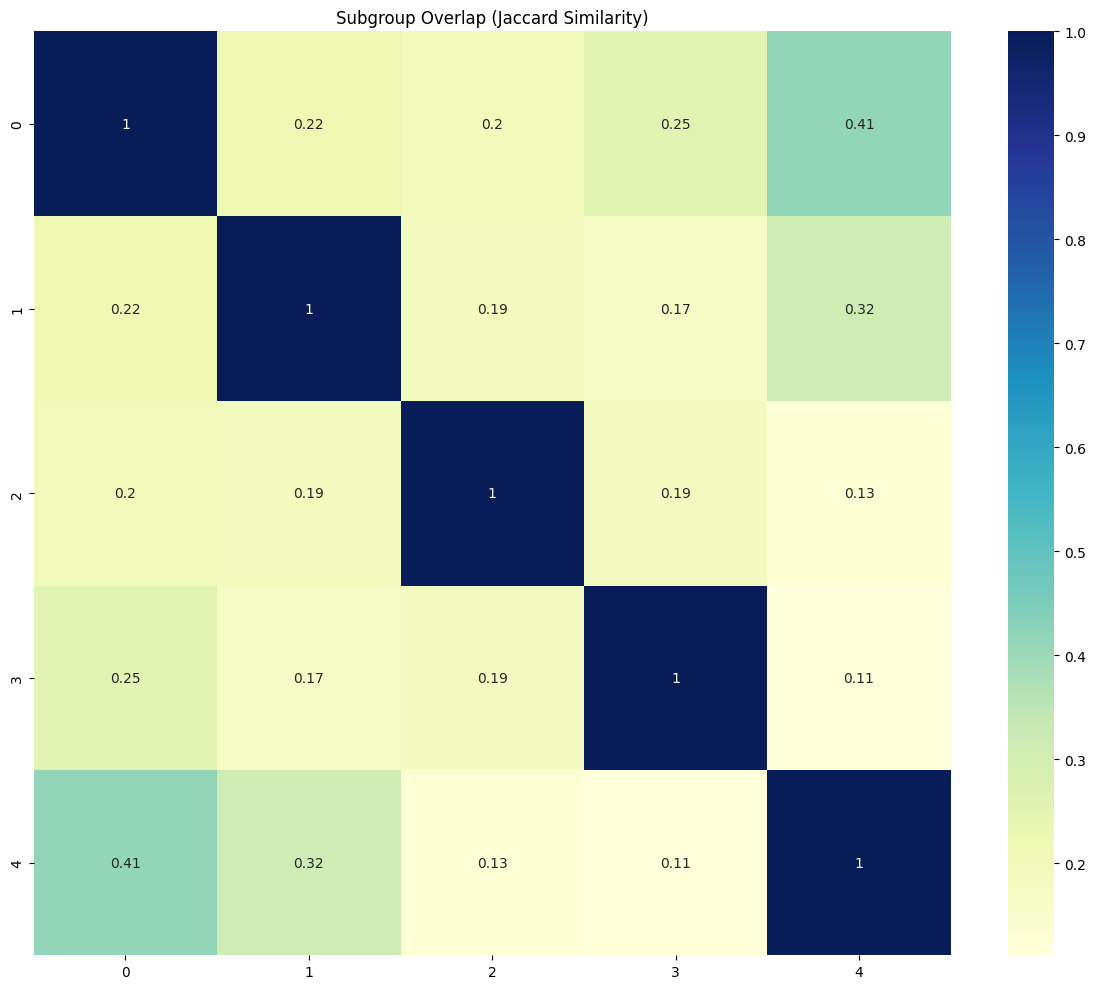

,wracc,subgroup
0,0.034482,session_time_bin=='120 < X'
1,0.034218,search==True
2,0.029026,basket_add_bin=='1 < X < 4'
3,0.022716,is_mobile==False
4,0.017952,blogpost==True AND content_view==False AND sea...


In [ ]:
import pysubgroup as ps

target = ps.BinaryTarget ('purchased', True)
dataset = session_info_df[session_info_df['basket_add_count'] >= 1]

searchspace = ps.create_selectors(dataset, ignore=['purchased','checked_out', 'pages', 'product_classes', 'cart_items', 'cart_items_category', 'pre_purchase_pages', 'basket_checkout_count',  'basket_add_count',  'product_visit_count',  'order_created_count', 'client'])
task = ps.SubgroupDiscoveryTask (
    dataset,
    target,
    searchspace,
    result_set_size=200,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch(beam_width_adaptive=True).execute(task)

pruned_df = prune_and_visualize(result.to_dataframe(), dataset)
pruned_df

In [ ]:
pruned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,wracc,subgroup
0,0.034482,session_time_bin=='120 < X'
1,0.034218,search==True
2,0.029026,basket_add_bin=='1 < X < 4'
3,0.022716,is_mobile==False
4,0.017952,blogpost==True AND content_view==False AND sea...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Mobile users

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



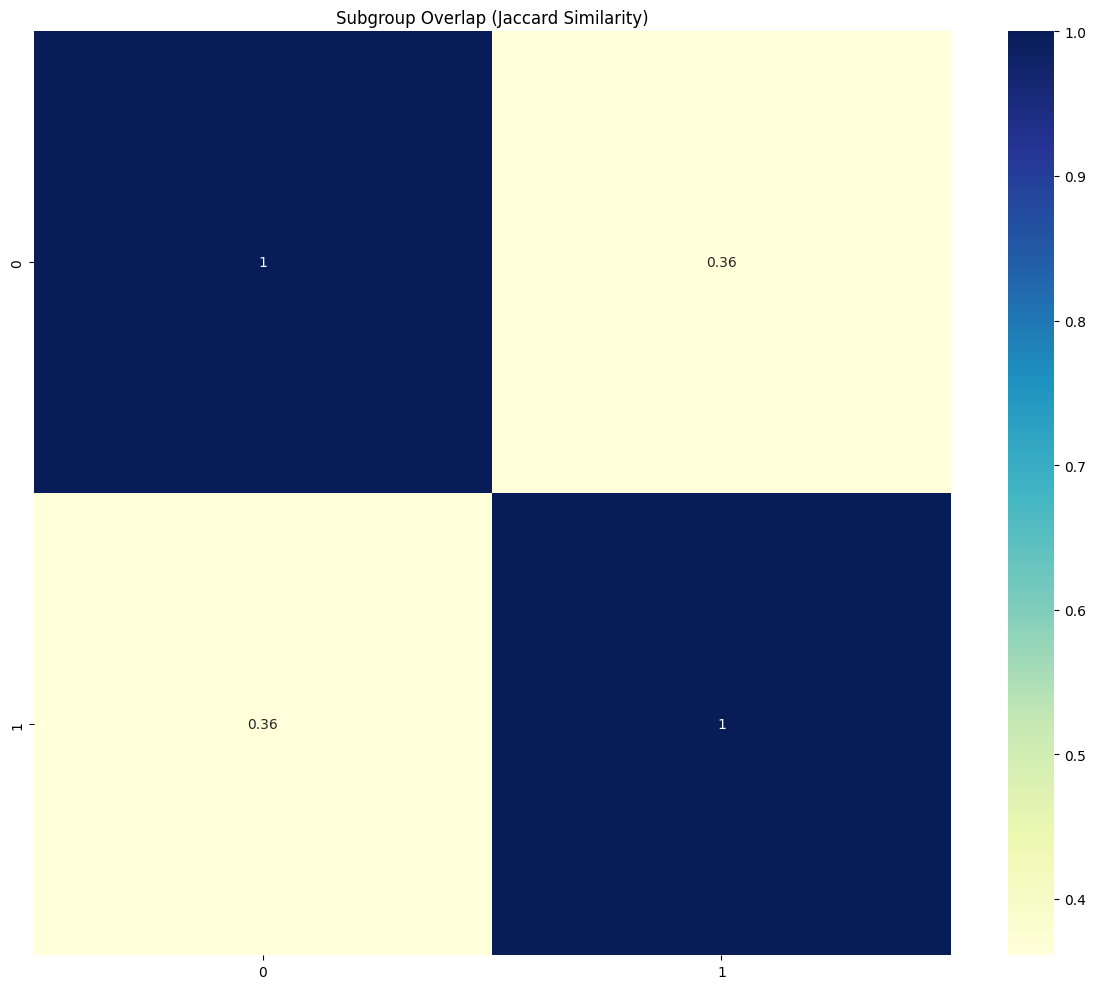

,wracc,subgroup
0,0.044145,session_time_bin=='1 < X < 5'
1,0.033291,basket_add_bin=='1' AND operational_system=='A...


In [ ]:
import pysubgroup as ps

target = ps.BinaryTarget ('purchased', False)
# dataset of users that inserted items in the cart and are on mobile
dataset = session_info_df[(session_info_df['basket_add_count'] >= 1) & (session_info_df['search'] == False)]

searchspace = ps.create_selectors(dataset, ignore=['purchased','checked_out', 'pages', 'product_classes', 'cart_items', 'cart_items_category', 'pre_purchase_pages', 'basket_checkout_count',  'basket_add_count',  'product_visit_count',  'order_created_count', 'client'])
task = ps.SubgroupDiscoveryTask (
    dataset,
    target,
    searchspace,
    result_set_size=200,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch(beam_width_adaptive=True).execute(task)

pruned_df = prune_and_visualize(result.to_dataframe(), dataset)
pruned_df

## Users that navigated a lot but didn't purchased

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



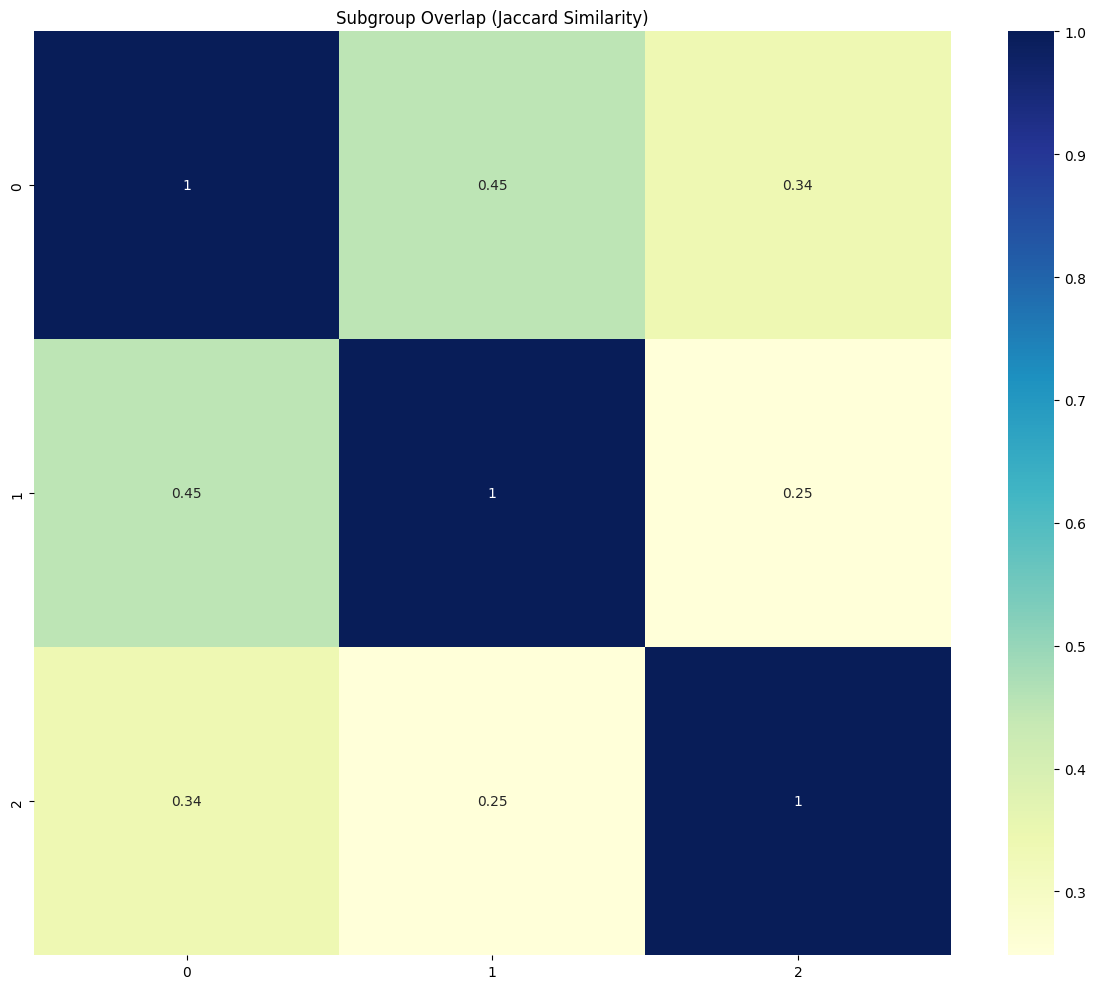

,wracc,subgroup
0,0.024820,basket_add_bin=='1 < X < 4' AND comparision_ad...
1,0.015150,basket_add_bin=='1 < X < 4' AND product_visit_...
2,0.009157,basket_add_bin=='1 < X < 4' AND comparision_ad...


In [ ]:
import pysubgroup as ps

target = ps.BinaryTarget ('purchased', False)
# dataset of users that inserted items in the cart and are on mobile
dataset = session_info_df[(session_info_df['session_time_bin'] == '120 < X')]

searchspace = ps.create_selectors(dataset, ignore=['session_time_bin', 'purchased','checked_out', 'pages', 'product_classes', 'cart_items', 'cart_items_category', 'pre_purchase_pages', 'basket_checkout_count',  'basket_add_count',  'product_visit_count',  'order_created_count', 'client'])
task = ps.SubgroupDiscoveryTask (
    dataset,
    target,
    searchspace,
    result_set_size=200,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch(beam_width_adaptive=True).execute(task)

pruned_df = prune_and_visualize(result.to_dataframe(), dataset)
pruned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



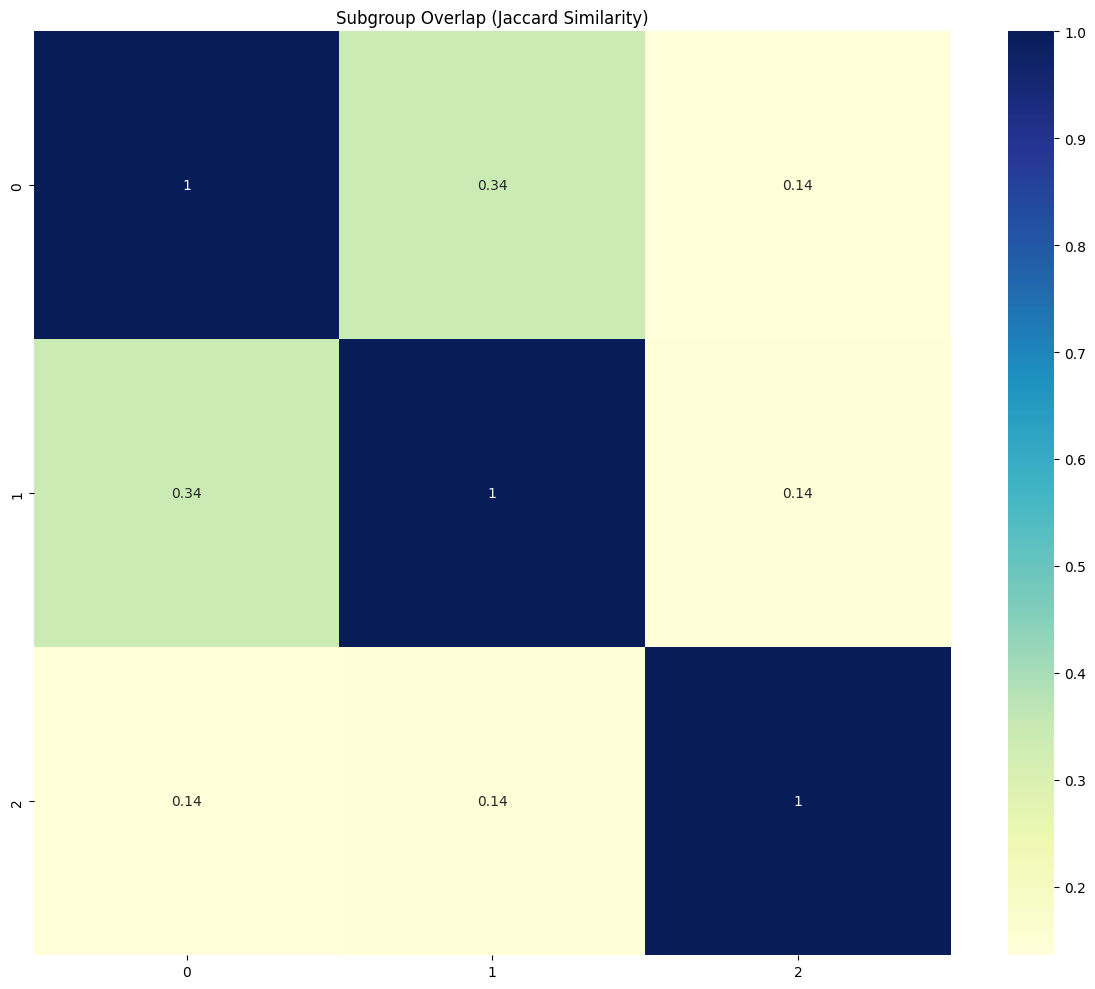

,wracc,subgroup
0,0.004665,operational_system=='Windows'
1,0.002226,blogpost==True AND filter_brand==True AND is_m...
2,0.001957,operational_system=='Windows' AND product_visi...


In [ ]:
import pysubgroup as ps

target = ps.BinaryTarget ('comparision_add', True)
# dataset of users that inserted items in the cart and are on mobile
dataset = session_info_df

searchspace = ps.create_selectors(dataset, ignore=['comparision_add', 'checked_out', 'pages', 'product_classes', 'cart_items', 'cart_items_category', 'pre_purchase_pages', 'basket_checkout_count',  'basket_add_count',  'product_visit_count',  'order_created_count', 'client'])
task = ps.SubgroupDiscoveryTask (
    dataset,
    target,
    searchspace,
    result_set_size=200,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch(beam_width_adaptive=True).execute(task)

pruned_df = prune_and_visualize(result.to_dataframe(), dataset)
pruned_df

## Misc

In [ ]:
import pysubgroup as ps
import numpy as np
import pandas as pd

target = ps.BinaryTarget('purchased', False)
dataset = session_info_df[session_info_df['basket_add_count'] >= 1]

searchspace = ps.create_selectors(dataset, ignore=['purchased', 'session_time_bin', 'basket_add_bin', 'checked_out', 'pages', 'product_classes', 'cart_items', 'cart_items_category', 'pre_purchase_pages', 'basket_checkout_count',  'basket_add_count',  'product_visit_count',  'order_created_count', 'client'])
task = ps.SubgroupDiscoveryTask(
    dataset,
    target,
    searchspace,
    result_set_size=200,
    depth=4,
    qf=ps.WRAccQF())

# Execute the subgroup discovery
result = ps.DFS().execute(task)

# Convert the result to a DataFrame
result_df = result.to_dataframe()

def jaccard_similarity(sg1, sg2, dataset):
    sg1_cover = sg1.covers(dataset)
    sg2_cover = sg2.covers(dataset)

    intersection = np.sum(sg1_cover & sg2_cover)
    union = np.sum(sg1_cover | sg2_cover)
    return intersection / union if union > 0 else 0

def prune_redundant_subgroups(result_df, dataset, similarity_threshold=0.5):
    pruned_indices = []
    for i, row in result_df.iterrows():
        sg = row['subgroup']
        is_redundant = False
        for j in pruned_indices:
            if jaccard_similarity(sg, result_df.loc[j, 'subgroup'], dataset) > similarity_threshold:
                is_redundant = True
                break
        if not is_redundant:
            pruned_indices.append(i)
    return result_df.loc[pruned_indices]

# Prune redundant subgroups
pruned_df = prune_redundant_subgroups(result_df, dataset)

pruned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.040396,is_mobile==True AND search==False,877,1811,755,1408,934,0.484263,0.515737,0.536222,0.463778,0.860889,0.699143,0.777471,1.107295
90,0.025023,filter_generic==False AND filter_price==False ...,671,1811,567,1408,1140,0.370514,0.629486,0.402699,0.597301,0.845007,0.737719,0.777471,1.086867
143,0.021495,comparision_add==False AND product_visit_bin==...,485,1811,416,1408,1326,0.267808,0.732192,0.295455,0.704545,0.857732,0.748115,0.777471,1.103233
172,0.017746,filter_brand==False AND filter_generic==False ...,450,1811,382,1408,1361,0.248482,0.751518,0.271307,0.728693,0.848889,0.753857,0.777471,1.091859
183,0.016997,filter_generic==True AND is_mobile==True AND s...,372,1811,320,1408,1439,0.205411,0.794589,0.227273,0.772727,0.860215,0.756081,0.777471,1.106427


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



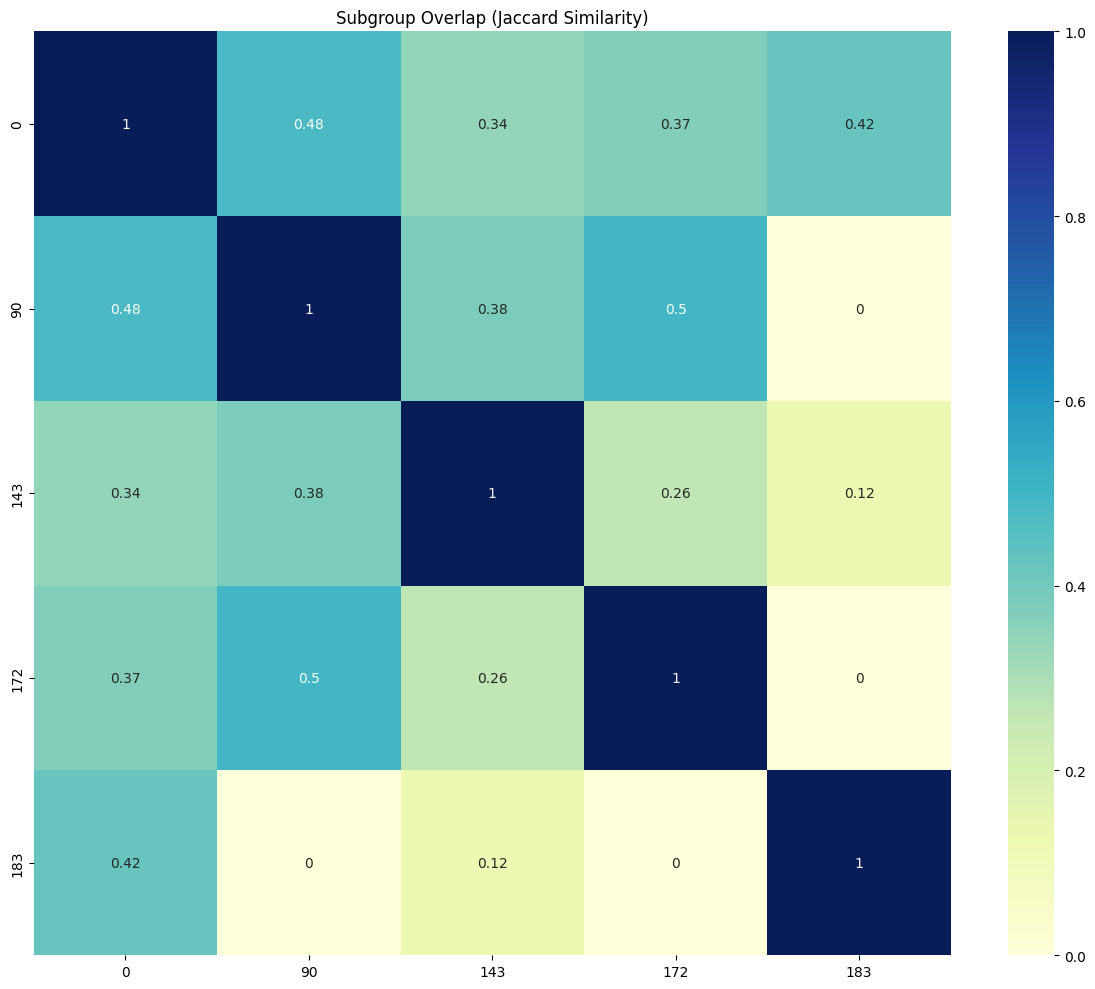

In [ ]:
import seaborn as sns

def create_overlap_matrix(df, dataset):
    n = len(df)
    overlap = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            overlap[i, j] = jaccard_similarity(df['subgroup'].iloc[i], df['subgroup'].iloc[j], dataset)
    return pd.DataFrame(overlap, index=df.index, columns=df.index)

overlap_matrix = create_overlap_matrix(pruned_df, dataset)

plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, annot=True, cmap='YlGnBu')
plt.title('Subgroup Overlap (Jaccard Similarity)')
plt.tight_layout()
plt.show()

In [ ]:
pruned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.040396,is_mobile==True AND search==False,877,1811,755,1408,934,0.484263,0.515737,0.536222,0.463778,0.860889,0.699143,0.777471,1.107295
90,0.025023,filter_generic==False AND filter_price==False ...,671,1811,567,1408,1140,0.370514,0.629486,0.402699,0.597301,0.845007,0.737719,0.777471,1.086867
143,0.021495,comparision_add==False AND product_visit_bin==...,485,1811,416,1408,1326,0.267808,0.732192,0.295455,0.704545,0.857732,0.748115,0.777471,1.103233
172,0.017746,filter_brand==False AND filter_generic==False ...,450,1811,382,1408,1361,0.248482,0.751518,0.271307,0.728693,0.848889,0.753857,0.777471,1.091859
183,0.016997,filter_generic==True AND is_mobile==True AND s...,372,1811,320,1408,1439,0.205411,0.794589,0.227273,0.772727,0.860215,0.756081,0.777471,1.106427


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



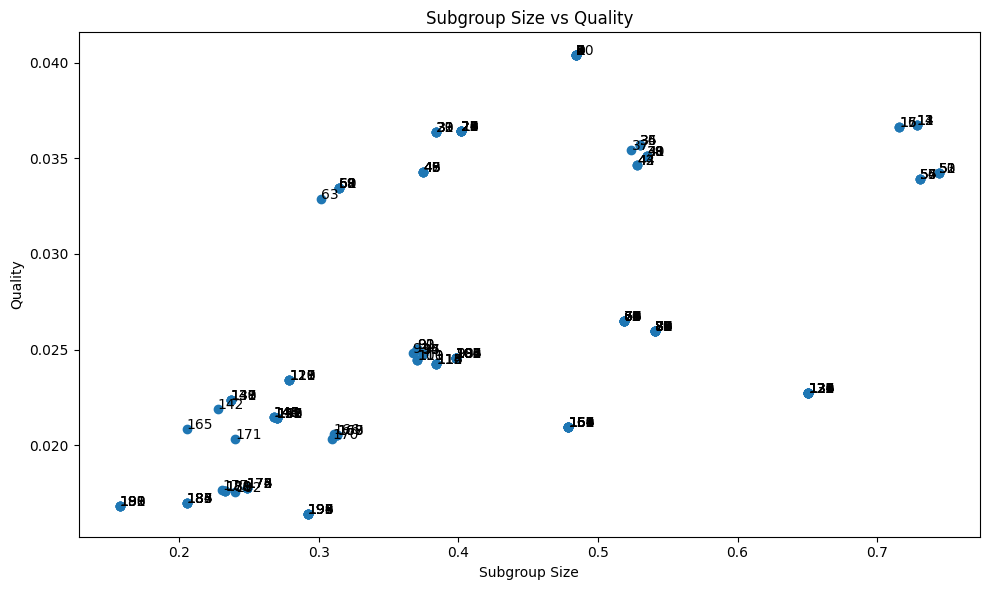

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(result_df['relative_size_sg'], result_df['quality'])
for i, txt in enumerate(result_df.index):
    plt.annotate(txt, (result_df['relative_size_sg'].iloc[i], result_df['quality'].iloc[i]))
plt.xlabel('Subgroup Size')
plt.ylabel('Quality')
plt.title('Subgroup Size vs Quality')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



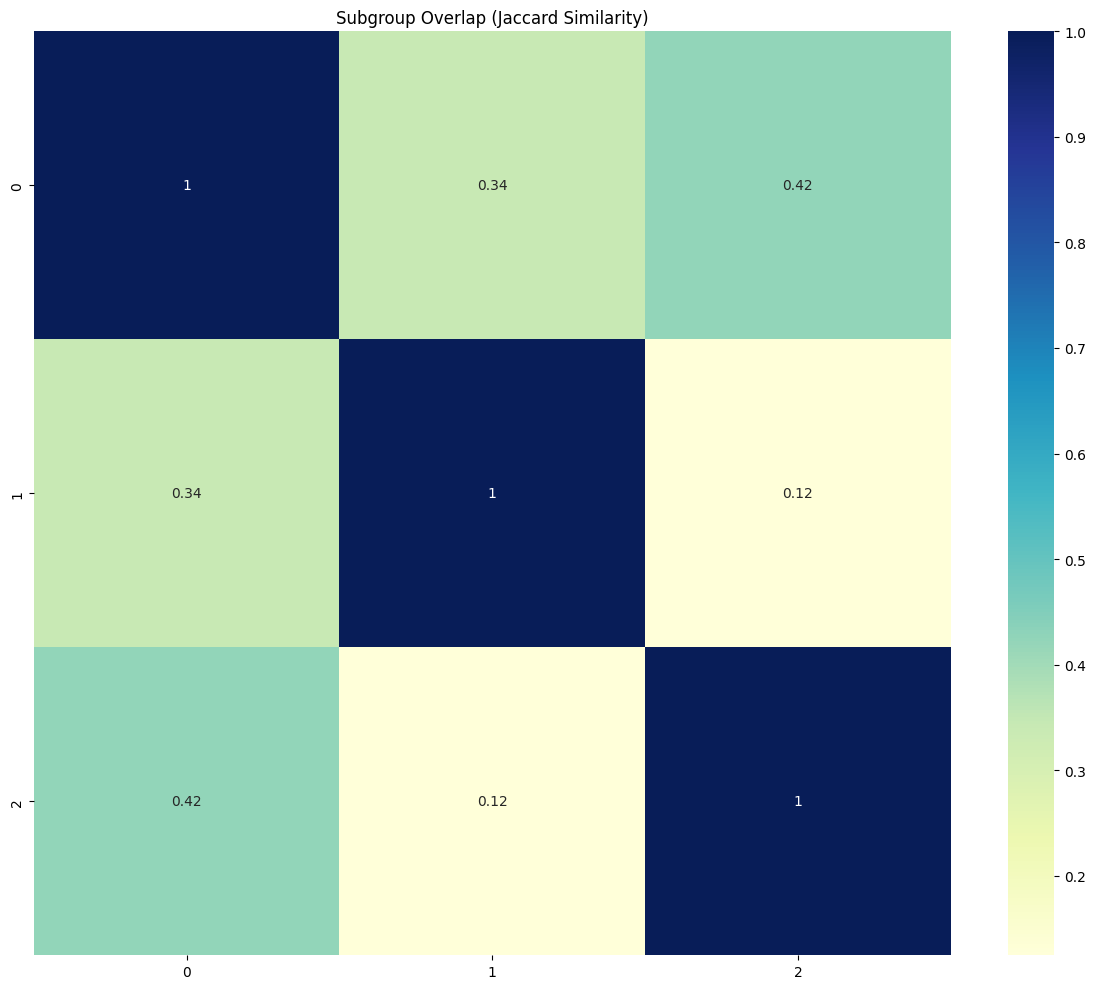

In [ ]:


# Example usage:
pruned_df = prune_and_visualize(result_df, dataset)


# Drafts

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
session_df = session_info_df
# Convert pages visited per session into a list of lists format
pages_accessed = session_info_df[session_info_df['basket_checkout_count'] >= 1]['pages'].tolist()

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit and transform the data into a one-hot encoded DataFrame
onehot = te.fit_transform(pages_accessed)

# Convert the one-hot encoded DataFrame into a DataFrame
df = pd.DataFrame(onehot, columns=te.columns_)

# Find frequent itemsets using Apriori with minimum support of 0.25
frequent_itemsets = apriori(df, min_support=0.25, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
filter_frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) > 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print("Frequent Itemsets:")
# show filter_frequent_itemsets ordered by support
filter_frequent_itemsets.sort_values(by='support', ascending=False)

Frequent Itemsets:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
8,0.521739,"(CHECKOUT-OP, FILTER-GENERIC)"
7,0.315942,"(CHECKOUT-OP, FILTER-BRAND)"
10,0.303623,"(CHECKOUT-OP, ORDER-CREATE)"
9,0.294928,"(CHECKOUT-OP, LOGIN)"
12,0.265217,"(CHECKOUT-OP, SEARCH)"
11,0.256522,"(REGISTER, CHECKOUT-OP)"


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import association_rules

# Generate association rules with a minimum confidence of 0.1
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Display the rules
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(CHECKOUT-OP),(FILTER-BRAND),1.000000,0.315942,0.315942,0.315942,1.0,0.0,1.0,0.0
1,(FILTER-BRAND),(CHECKOUT-OP),0.315942,1.000000,0.315942,1.000000,1.0,0.0,inf,0.0
2,(CHECKOUT-OP),(FILTER-GENERIC),1.000000,0.521739,0.521739,0.521739,1.0,0.0,1.0,0.0
3,(FILTER-GENERIC),(CHECKOUT-OP),0.521739,1.000000,0.521739,1.000000,1.0,0.0,inf,0.0
4,(CHECKOUT-OP),(LOGIN),1.000000,0.294928,0.294928,0.294928,1.0,0.0,1.0,0.0
5,(LOGIN),(CHECKOUT-OP),0.294928,1.000000,0.294928,1.000000,1.0,0.0,inf,0.0
6,(CHECKOUT-OP),(ORDER-CREATE),1.000000,0.303623,0.303623,0.303623,1.0,0.0,1.0,0.0
7,(ORDER-CREATE),(CHECKOUT-OP),0.303623,1.000000,0.303623,1.000000,1.0,0.0,inf,0.0
8,(REGISTER),(CHECKOUT-OP),0.256522,1.000000,0.256522,1.000000,1.0,0.0,inf,0.0
9,(CHECKOUT-OP),(REGISTER),1.000000,0.256522,0.256522,0.256522,1.0,0.0,1.0,0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



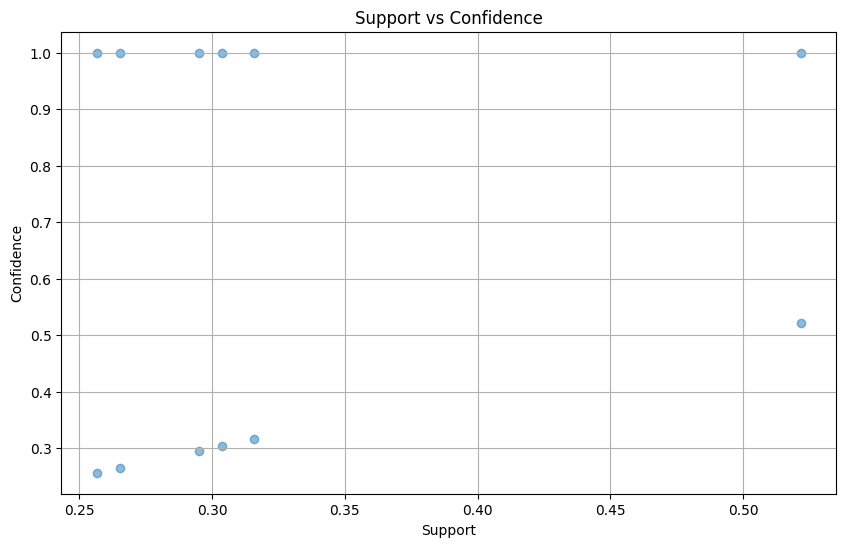

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, marker="o")
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.grid(True)
plt.show()

In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,AR-1091,AR-1100,AR-1134,AR-1191,AR-1193,AR-1194,AR-1195,AR-137,AR-153,AR-170,...,PR-9546,PR-9665,PR-9789,PR-9814,PR-9993,PR-list,PR-products?browsingBrandId=-1,PR-sidebar?browsingBrandId=-1,REGISTER,SEARCH
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1376,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1377,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1378,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

filtered_session_df = session_info_df[session_info_df['basket_checkout_count'] >= 1]
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(df)

# Add clustering results to the original DataFrame
filtered_session_df['cluster'] = clusters
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-79-ef571cfccfb6>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



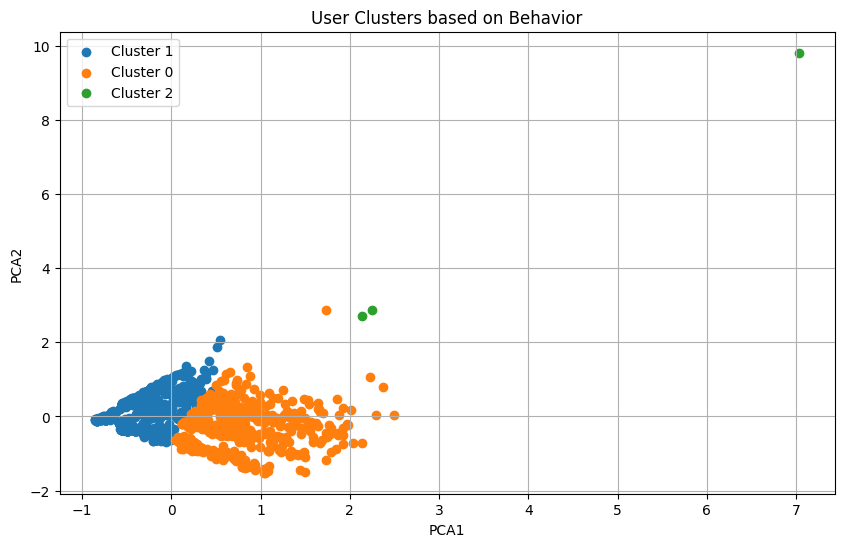

In [ ]:
plt.figure(figsize=(10, 6))
for cluster in pca_df['cluster'].unique():
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('User Clusters based on Behavior')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=2.05)
print("Association Rules with Lift > 2.05:\n")
for index, rule in rules.iterrows():
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    support = rule['support']
    confidence = rule['confidence']
    lift = rule['lift']
    print(f"Rule {index+1}: {antecedents} -> {consequents}")
    print(f"Support: {support:.4f}, Confidence: {confidence:.4f}, Lift: {lift:.4f}\n")

Association Rules with Lift > 2.05:



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
filtered_session_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,client,operational_system,is_mobile,session_time_bin,blogpost,filter_generic,filter_price,filter_brand,search,comparision_add,...,basket_add_bin,product_visit_bin,basket_checkout_count,basket_add_count,product_visit_count,order_created_count,cart_items_category,purchased,pre_purchase_pages,cluster
14,10.114.99.92,Windows,False,10 < X < 30,True,True,False,True,False,False,...,1 < X < 4,1 < X < 4,2,2,3,0,"[Home and Kitchen > Audio and Visual, Home and...",False,"[BR-tv, FILTER-BRAND, PR-64267, BA-64267, PR-3...",1
28,10.145.254.153,Windows,False,120 < X,True,True,False,False,True,False,...,1,4 < X < 10,1,1,6,1,[Digital Goods > Mobile Phones],True,"[PR-31097, FILTER-GENERIC, PR-65274, PR-65271,...",1
36,10.233.251.23,Windows,False,10 < X < 30,True,True,False,True,False,False,...,1,1 < X < 4,1,1,2,0,[Home and Kitchen > Home Appliances],False,"[FILTER-GENERIC, PR-11142, BA-11142, FILTER-GE...",1
55,10.30.1.215,Windows,False,30 < X < 60,True,True,False,True,True,False,...,1 < X < 4,10 <= X,2,2,14,1,"[Home and Kitchen > Home Appliances, Home and ...",True,"[BR-home-appliances, FILTER-GENERIC, FILTER-BR...",0
57,10.30.2.70,Windows,False,120 < X,True,True,False,True,False,False,...,1 < X < 4,4 < X < 10,2,2,6,0,"[Home and Kitchen > Home Appliances, Home and ...",False,"[FILTER-GENERIC, BR-stove-and-oven, FILTER-GEN...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38967,95.64.117.142,Android,True,30 < X < 60,True,True,False,True,False,False,...,1,1 < X < 4,1,1,2,1,[Digital Goods > Laptops and Computers],True,"[BR-digital-supplies, BR-laptop, FILTER-BRAND,...",0
38982,95.64.22.205,Android,True,10 < X < 30,True,False,False,False,False,False,...,1,4 < X < 10,1,1,7,0,[Digital Goods > Laptops and Computers],False,"[PR-62974, BR-laptop, PR-62974, PR-62796, PR-6...",1
39019,95.64.59.159,Android,True,10 < X < 30,True,False,False,False,False,False,...,1,1 < X < 4,2,1,0,0,[Home and Kitchen > Home Appliances],False,[BA-11669],0
39020,95.64.59.39,Android,True,5 < X < 10,True,False,False,False,False,False,...,1,1,1,1,1,0,[N/A],False,"[PR-64677, BA-64677]",1


In [ ]:
!pip install plotly


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import networkx as nx
import plotly.graph_objs as go
from collections import Counter

# Initialize directed graph
G = nx.DiGraph()

# Process each session to add edges to the graph
edge_list = []
for session in filtered_session_df['client'].unique():
    session_data = filtered_session_df[filtered_session_df['client'] == session]
    pages = session_data['pages'].tolist()

    # Ensure pages list is flat
    if len(pages) > 1 and isinstance(pages[0], list):
        pages = pages[0]  # If pages is a list of lists, take the first list

    # Ensure pages list is not empty
    if len(pages) > 1:
        # Create edges from consecutive page visits
        edges = [(pages[i], pages[i+1]) for i in range(len(pages)-1)]
        edge_list.extend(edges)

# Count frequency of each edge
edge_counter = Counter(edge_list)

# Filter to get top N most common edges
top_edges = edge_counter.most_common(100000)  # Adjust N as needed

# Identify top 5 most common paths (edges)
top_5_edges = [edge for edge, weight in edge_counter.most_common(50)]

# Add filtered edges with weights to the graph
for edge, weight in top_edges:
    G.add_edge(edge[0], edge[1], weight=weight)

# Create plotly graph
pos = nx.spring_layout(G, k=0.5)  # You can adjust the value of k for better spacing
edge_trace = []
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(size=10, color='skyblue'),
)

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    node_trace['text'] += (node,)

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = edge[2]['weight']
    color = 'red' if (edge[0], edge[1]) in top_5_edges else 'gray'
    edge_trace.append(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=weight * 0.1, color=color),
            hoverinfo='none',
            mode='lines'
        )
    )

fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(
                    title='Interactive User Navigation Graph with Top 5 Paths Highlighted',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
cliques = list(nx.find_cliques(G))

# Print cliques
for i, clique in enumerate(cliques):
    print(f"Clique {i + 1}: {clique}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



NetworkXNotImplemented: not implemented for directed type

In [ ]:
import argparse
import logging
import random
from gsppy.gsp import GSP
logging.basicConfig(level=logging.DEBUG)

result = GSP(pages_accessed).search(0.25)
result

In [ ]:
max_length = 999
# Filter out frequent sequential patterns based on maximum length
filtered_patterns = [pattern for pattern in result if len(pattern) <= max_length]

# Display the frequent sequential patterns
for pattern in filtered_patterns:
    print(pattern)



In [ ]:
session_info_df[session_info_df['basket_checkout_count'] >= 1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Setting patterns into a suitable format for analysis
patterns = onehot

# Cluster users using K-means
kmeans = KMeans(n_clusters=10,  n_init=20)
clusters = kmeans.fit_predict(patterns)

In [ ]:
# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(patterns[:, 0], patterns[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters of Users with Similar Navigational Patterns')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes (users) to the graph
for i in range(len(patterns)):
    # Assign cluster as a node attribute
    G.add_node(i, label=f"User {i}", cluster=clusters[i])

# Add edges between similar users (in the same cluster)
for i in range(len(patterns)):
    for j in range(i + 1, len(patterns)):
        if clusters[i] == clusters[j]:
            G.add_edge(i, j)

# Visualize the graph
plt.figure(figsize=(10, 8))
# Layout for the graph
pos = nx.spring_layout(G)

# Draw nodes colored by cluster
node_color = [clusters[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=plt.cm.tab10, node_size=200)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title('Clusters of Users with Similar Navigational Patterns')
# plt.axis('off')
plt.show()